## Задача

Перед вами стоит бизнес-задача — на основании имеющихся данных подготовить аналитический отчет, который в дальнейшем поможет продюсерам образовательных программ эффективно выстраивать стратегию по обновлению и улучшению курсов. В начале отчета предлагается оформить емкий описательный блок по каждому курсу на основании рассчитанных показателей. Далее – посчитать потенциальную нагрузку на преподавателей, чтобы оценить необходимость расширения штата сотрудников. Затем идет блок из двух пунктов по анализу качества контента курсов, где необходимо выявить проблемные модули, которые, возможно, требуют доработки. Также стоит задача выявить потенциальную сезонность. В конце предлагаем задание для самостоятельной разработки метрики успеваемости студентов, чтобы найти тех, кто значительно хуже справляется с прохождением курса. Каждый из пунктов анализа нужно сопроводить аналитическим выводом на основании рассчитанных метрик.

## Codebook

`courses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `title` – название курса <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `field` – сфера, к которой относится курс <br> <br><br>
`students.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp; `city` – город студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `birthday` – день рождения студента <br> <br><br>
`course_contents.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `course_id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `module_title` – название модуля <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_title` – название урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_token` – токен урока <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `is_video` – наличие видео *(true/false)* <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `is_homework` – наличие домашней работы *(true/false)* <br>
<br><br>
`progresses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `student_id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `course_id` – идентификатор курса <br> <br><br>
`progress_phases.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `progress_id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `status` – статус прохождения урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `start_date` – дата начала <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `finish_date` – дата окончания <br>
<br><br>

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import math
import numpy as np
%matplotlib inline
import re

### 1. Описание и начальная работа с данными
Посчитайте:
- общее количество курсов в датасете,
- количество модулей на каждом курсе,
- количество уроков в каждом модуле на каждом курсе,
- медианное количество уроков в модуле на каждом курсе,
- количество учеников на каждом курсе
- минимальный, максимальный, средний, медианный возраст студентов
- минимальный, максимальный, средний, медианный возраст студентов на каждом курсе

Постройте bar-chart, отражающий количество студентов на каждом курсе. 
Постройте горизонтальный bar-chart, отражающий количество студентов на каждом курсе. 

**Соединение таблиц**

In [6]:
# считываем данные 
courses = pd.read_csv('courses.csv') 
progresses = pd.read_csv('progresses.csv')
course_contents = pd.read_csv('course_contents.csv') 
progress_phases = pd.read_csv('progress_phases.csv') 
students = pd.read_csv('students.csv')

In [7]:
# соединение таблиц (без студентов)
progresses_summary_df = progress_phases.merge(
    progresses, how='left', left_on='progress_id', right_on='id').drop(['id'], axis='columns')

courses_summary_df = course_contents.merge(
    courses, how='left', left_on='course_id', right_on='id').drop(['id'], axis='columns')

summary_df = progresses_summary_df.merge(courses_summary_df)

In [8]:
# присоединение к общей таблице summary_df таблицы со студентами
summary_and_students = summary_df.merge(
    students, how='left', left_on='student_id', right_on='id').drop(['id'], axis='columns')

In [9]:
# перестановка и переименование столбцов 
summary_df = summary_df[['progress_id', 'module_number', 'lesson_number', 'status',
                         'start_date', 'finish_date', 'student_id', 'course_id', 'title',
                         'field', 'module_title', 'lesson_title', 'lesson_token', 'is_video','is_homework']]

summary_df.rename(columns = {'title':'course_title'}, inplace=True)

In [10]:
summary_df.head(3)

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
1,3b9dce04f32da32763124602557f92a3,2,4,done,2019-03-18 14:23:17.328374+00,2019-03-18 14:54:50.979612+00,03151bc73bdb29fe1be1443c6d83e22f,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
2,73e17a05355852fe65b785c82c37d1ad,2,4,done,2019-07-09 09:18:46.19862+00,2019-07-11 08:03:09.222385+00,ed235f47e16da6e83d3f1cb511f38ea6,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False


**Посчитайте** 
1. общее количество курсов в датасете 
2. количество модулей на каждом курсе 
3. количество уроков в каждом модуле на каждом курсе
4. медианное количество уроков в модуле на каждом курсе
5. количество учеников на каждом курсе
6. минимальный, максимальный, средний, медианный возраст студентов
7. минимальный, максимальный, средний, медианный возраст студентов на каждом курсе

**1. Общее количество курсов в датасете**

In [11]:
summary_df.course_title.nunique()

15

 **2. Количество модулей на каждом курсе**

In [12]:
summary_df.groupby('course_title')['module_title'].nunique().sort_values().reset_index()

,course_title,module_title
0,PHP-разработчик с 0 до PRO. Часть 1,8
1,Веб-вёрстка для начинающих 2.0,8
2,Excel Базовый,9
3,Java-разработчик c нуля,9
4,SMM-маркетолог от А до Я,11
5,Java-разработчик,17
6,Веб-дизайн PRO 2.0,17
7,Веб-дизайн Базовый,17
8,Руководитель digital-проектов,17
9,JavaScript с нуля,18


 **3. Количество уроков в каждом модуле на каждом курсе**

In [13]:
summary_df.groupby(['course_title','module_title'])['lesson_number'].nunique()

course_title                   module_title                                       
Excel Базовый                   Визуализация данных Excel                              5
                               Основной функционал Excel                              11
                               Основной функционал Excel (продолжение)                 7
                               Сводные таблицы Excel                                   5
                               Формулы и функции Excel. Более сложные формулы          5
                                                                                      ..
Руководитель digital-проектов  Решение факапов. Lean/TOC. Обзор.                       5
                               Требовательность digital-продюсера                      4
                               Управление временем                                     4
                               Управление дизайнерами. Разработка дизайна по scrum     7
                           

**4. Медианное количество уроков в модуле на каждом курсе**

In [14]:
a = summary_df.groupby(['course_title', 'module_title'])['lesson_number'].nunique() \
    .groupby(['course_title' , 'module_title']).agg('median').reset_index()
a

,course_title,module_title,lesson_number
0,Excel Базовый,Визуализация данных Excel,5
1,Excel Базовый,Основной функционал Excel,11
2,Excel Базовый,Основной функционал Excel (продолжение),7
3,Excel Базовый,Сводные таблицы Excel,5
4,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5
...,...,...,...
224,Руководитель digital-проектов,Решение факапов. Lean/TOC. Обзор.,5
225,Руководитель digital-проектов,Требовательность digital-продюсера,4
226,Руководитель digital-проектов,Управление временем,4
227,Руководитель digital-проектов,Управление дизайнерами. Разработка дизайна по ...,7


**5. Количество учеников на каждом курсе**

In [15]:
sum_by_course = summary_df.groupby(['course_title', 'field'])['student_id']\
    .agg('nunique')\
    .sort_values()\
    .reset_index()

sum_by_course

,course_title,field,student_id
0,SMM-маркетолог от А до Я,Marketing,506
1,Веб-дизайн Базовый,Design,518
2,Java-разработчик c нуля,Development,581
3,Анимация интерфейсов,Design,598
4,Веб-разработчик,Development,628
5,Руководитель digital-проектов,Business,685
6,Java-разработчик,Development,763
7,Excel Базовый,Business,782
8,PHP-разработчик с 0 до PRO. Часть 1,Development,854
9,JavaScript с нуля,Development,966


**6. Минимальный, максимальный, средний, медианный возраст студентов**

In [16]:
# удаление пропущенных значений и изменение типа данных 
students.dropna(inplace = True)
age = pd.to_datetime(students.birthday, errors = 'coerce')

# создание столбца age с возрастом студентов и фильтрация по возрасту (возраст выбран произвольно) 
students['age'] = (pd.datetime.today().year - age.dt.year)
students = students[(students['age'] >= 17) & (students['age'] <= 60)]
 
students['age'].agg(['min', 'max', 'mean'])

C:\Users\e.boykova\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


min     17.000000
max     60.000000
mean    31.265583
Name: age, dtype: float64

**7. Минимальный, максимальный, средний, медианный возраст студентов на каждом курсе**

In [17]:
# переименовываем столбцы и меняем очередность как в таблице summary_df и переименовываем столбец
summary_and_students = summary_and_students[['progress_id', 'module_number', 'lesson_number', 'status',
                         'start_date', 'finish_date', 'student_id', 'course_id', 'title',
                         'field', 'module_title', 'lesson_title', 'lesson_token', 'is_video',
                        'is_homework','city', 'birthday']]

summary_and_students.rename(columns = {'title':'course_title'}, inplace=True)

In [18]:
# удаляем пропущенные значения из столбца 'birthday'
age_by_course = summary_and_students.dropna(subset = ['birthday'])

# преобразуем во временной формат столбец 'birthday'
age = pd.to_datetime(age_by_course.birthday, errors = 'coerce')

# создание столбца age с возрастом студентов и фильтрация по возрасту 
age_by_course['age'] = (pd.datetime.today().year - age.dt.year)
age_by_course = age_by_course[(age_by_course['age'] >= 17) & (age_by_course['age'] <=60)]

age = age_by_course.groupby('course_title')['age'].agg(['min', 'max', 'mean']).round()
age

C:\Users\e.boykova\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
C:\Users\e.boykova\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,min,max,mean
course_title,,,
Excel Базовый,18.0,59.0,35.0
Java-разработчик,17.0,56.0,31.0
Java-разработчик c нуля,17.0,56.0,32.0
JavaScript с нуля,17.0,59.0,30.0
PHP-разработчик с 0 до PRO. Часть 1,17.0,59.0,32.0
SMM-маркетолог от А до Я,19.0,53.0,30.0
UX-дизайн,18.0,59.0,32.0
Анимация интерфейсов,18.0,52.0,31.0
Веб-вёрстка для начинающих 2.0,17.0,59.0,30.0


*небольшие рачеты для выводов*

In [19]:
# Медианное число модулей
summary_df.groupby('course_title')['module_title'].nunique().agg('median')

17.0

In [20]:
# Минимальная дата
summary_df['start_date'].min()

'2016-03-10 07:00:19+00'

In [21]:
# Максимальная дата
summary_df['start_date'].max()

'2019-07-17 08:05:50.606895+00'

In [22]:
# подсчет количества курсов по сферам
courses_by_field = summary_df.groupby(['field'])['course_title'].unique().reset_index()

# так как в ячейках содержатся списки можно посчитать количество элементов в нем 
courses_by_field['len'] = courses_by_field['course_title'].map(len)
courses_by_field

,field,course_title,len
0,Business,"[Руководитель digital-проектов, Excel Базовый]",2
1,Design,"[Веб-дизайн PRO 2.0, UX-дизайн, Веб-дизайн с н...",5
2,Development,"[JavaScript с нуля, Веб-разработчик, Веб-вёрст...",6
3,Marketing,"[Интернет-маркетолог от Ingate, SMM-маркетолог...",2


In [23]:
# Подсчет 10-ти модулей с самым большим количеством уроков 
summary_df.groupby(['course_title','module_title'])['lesson_number'].nunique().nlargest(10).reset_index() 

,course_title,module_title,lesson_number
0,Интернет-маркетолог от Ingate,Email-маркетинг,29
1,Java-разработчик c нуля,"Числа, строки и даты",27
2,Интернет-маркетолог от Ingate,"SEO: больше, чем поисковая выдача (обновление ...",19
3,Интернет-маркетолог от Ingate,Контекстная реклама в Yandex Direct и Google A...,17
4,Интернет-маркетолог от Ingate,Таргетированная реклама в социальных сетях,16
5,Java-разработчик c нуля,Работа с файлами и сетью,15
6,Java-разработчик c нуля,Массивы и коллекции,13
7,Java-разработчик c нуля,Наследование и полиморфизм,13
8,Java-разработчик c нуля,Особенности ООП в Java,13
9,PHP-разработчик с 0 до PRO. Часть 1,База данных MySQL,13


In [24]:
# медианное число уроков по всем курсам 
summary_df.groupby(['course_title', 'module_title'])['lesson_number'].nunique().median()

5.0

In [25]:
# количество студентов по сферам
sum_by_field = sum_by_course.groupby('field')['student_id'].sum().reset_index()
sum_by_field.sort_values(by = 'student_id', ascending = False)

,field,student_id
1,Design,5992
2,Development,5796
3,Marketing,2674
0,Business,1467


In [26]:
# процент от общего количества студентов
sum_by_field['%'] = (sum_by_field['student_id'] * 100) / sum_by_field['student_id'].sum()
sum_by_field

,field,student_id,%
0,Business,1467,9.209618
1,Design,5992,37.616925
2,Development,5796,36.386465
3,Marketing,2674,16.786992


**Bar-chart, отражающий количество студентов на каждом курсе**

In [27]:
data = summary_and_students.groupby('course_title')['student_id'].agg('nunique').reset_index()

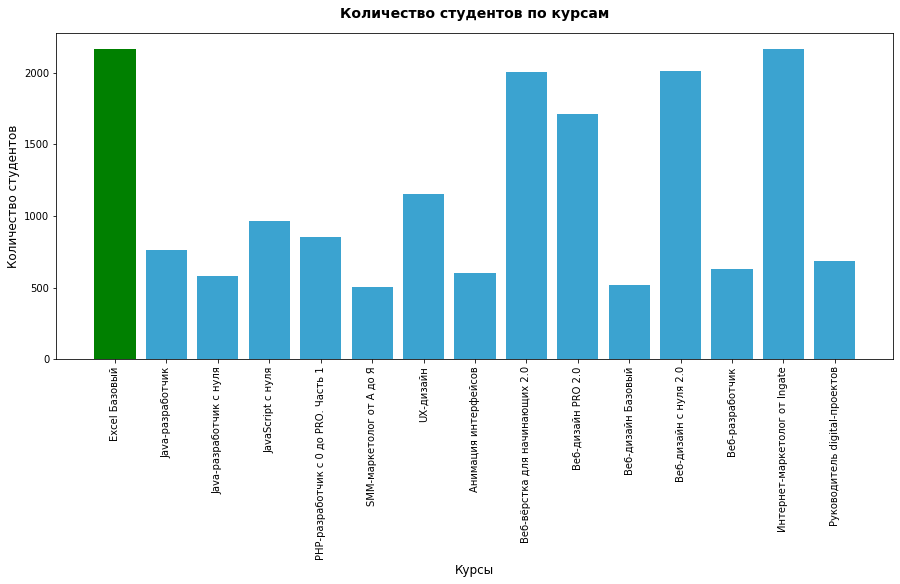

In [30]:
x = data['course_title']
y = data['student_id']

fig, ax = plt.subplots(figsize=(15, 6))

plt.title('Количество студентов по курсам', fontsize=14, fontweight = 'bold', pad = 15)
plt.bar(x, y, color = '#3BA3D0')
plt.bar(x = np.argmax(y.max), height=y.max() , color = 'green')

plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Количество студентов', fontsize=12)
plt.xlabel('Курсы', fontsize=12)
plt.show()

**Bar-chart, отражающий количество студентов по сферам и курсам**

In [31]:
unstacked_students_num = summary_and_students.groupby(['course_title','field'])['student_id'].nunique().to_frame().unstack()

# делаем сортировку
unstacked_students_num['sortby'] = unstacked_students_num.sum(axis=1)
unstacked_students_num = unstacked_students_num.sort_values('sortby').drop('sortby',axis=1)

unstacked_students_num.columns = ['Business','Design','Development','Marketing']

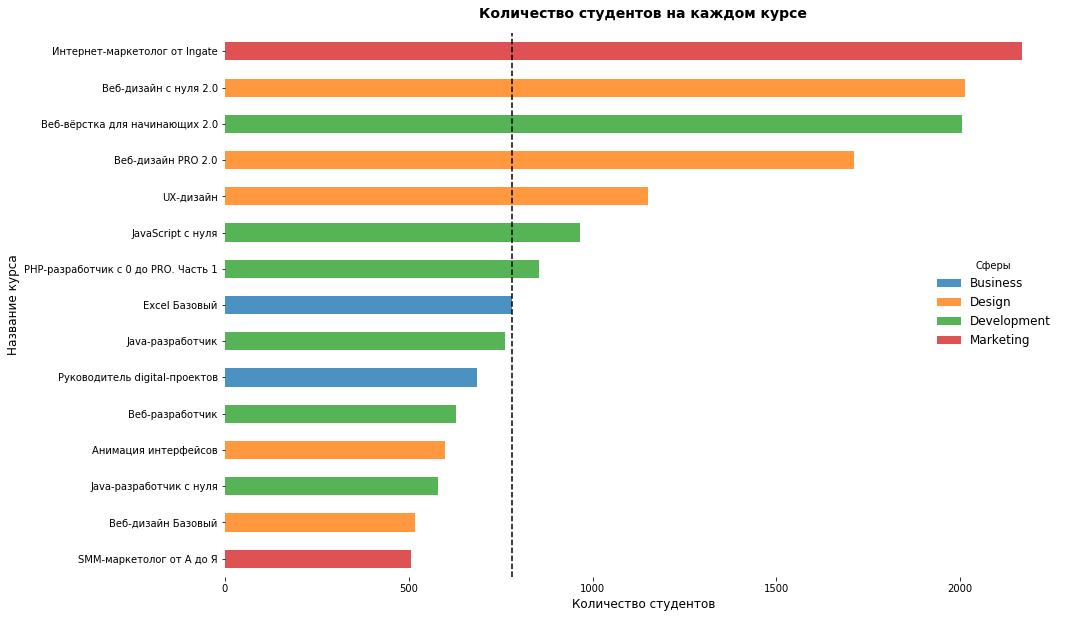

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))

ax = unstacked_students_num.plot(kind='barh', ax=ax, stacked=True, alpha = 0.8)
plt.axvline(x = summary_and_students.groupby('course_title')['student_id'].agg('nunique').median(), ls='--', color='k')

plt.title('Количество студентов на каждом курсе', fontsize=14, fontweight = 'bold', pad = 15)
plt.ylabel('Название курса', fontsize = 12)
plt.xlabel('Количество студентов', fontsize = 12)
ax.legend(bbox_to_anchor=(1, 0.6), frameon= False, title = 'Сферы', fontsize = 12)
plt.box(on=False)

plt.show()

##  Выводы по пункту 1

В датасете представлены данные с марта 2016 года по июль 2019 года. 

Всего 15 курсов, медианное количество модулей в каждом курсе – 17, минимальное число модулей - 8 в курсах «РНР-разработчик с 0 до PRO. Часть 1» и «Веб-верстка для начинающих 2.0», а максимальное количество модулей (21) в курсе «Анимация интерфейсов».  

Максимальное количество курсов принадлежит сфере Разработки (6), а минимальное к сферам Бизнеса и Маркетинга (2).

Самое большое количество уроков в модулях содержатся на курсах «Интернет-маркетолог от Ingate» и «Java-разработчик с нуля». Модули этих курсов содержат по 29 и 27 уроков соответственно.  

Самыми популярными курсами (более 2 т. человек) являются «Интернет-маркетолог от Ingate», «Веб-дизайн с нуля 2.0» и «Веб-верстка для начинающих 2.0».  По сферам количество студентов примерно одинаково в таких направлениях как Дизайн и Разработка (5992 и 5796 соответственно) что в сумме дает более 74% студентов, наименьшее количество студентов в сфере Бизнеса (1467). 

Данные о возрасте студентов по всем курсам следующие: минимальный возраст - 17 лет, максимальный 60 лет и средний возраст 30 лет. По курсам минимальный возраст практически не отличается (17-18 лет), но максимальный возраст значительно разнится. На таких курсах как «Веб-разработчик», «Веб-дизайн базовый» и «Анимация интерфейсов» максимальный возраст отличается на 9 лет от предельного возраста по остальным курсам.


## 2. Расчет потенциальной нагрузки на преподавателей

1. Рассчитать прирост студентов на каждом курсе в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно). Считать дату начала прохождения курса студентом по дате начала первой домашней работы.
2. На основании первого пункта построить line-graph с приростом студентов в каждом месяце для каждого курса. 
3. На основании первого пункта построить line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 
4. Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой. Построить line-graph по четвертому пункту.
5. Построить один line-graph для всех курсов по четвертому пункту. 15 линий на графике.
6. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

In [35]:
# в summary_and_students (основной дф со студентами) меняем формат столбцов на временной 
summary_and_students[['start_date', 'finish_date']] =  summary_and_students[["start_date", "finish_date"]].apply(pd.to_datetime)

# добавляем в дф 2 столбца 'start' и 'finish' сохраняем в них только год и месяц 
summary_and_students['start'] = summary_and_students.start_date.dt.to_period('M')
summary_and_students['finish'] = summary_and_students.finish_date.dt.to_period('M')

C:\Users\e.boykova\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [36]:
# проверим тип данных 
summary_and_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350677 entries, 0 to 350676
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   progress_id    350677 non-null  object             
 1   module_number  350677 non-null  int64              
 2   lesson_number  350677 non-null  int64              
 3   status         350677 non-null  object             
 4   start_date     350677 non-null  datetime64[ns, UTC]
 5   finish_date    334508 non-null  datetime64[ns, UTC]
 6   student_id     350677 non-null  object             
 7   course_id      350677 non-null  object             
 8   course_title   350677 non-null  object             
 9   field          350677 non-null  object             
 10  module_title   350677 non-null  object             
 11  lesson_title   350677 non-null  object             
 12  lesson_token   350677 non-null  object             
 13  is_video       350677 non-nul

In [30]:
# фильтр данных по домашней работе, так как не везде первое ДЗ в первом модуле  
hw_start = summary_and_students[((summary_and_students['module_number'] == 1) \
                    & (summary_and_students['lesson_title'] == 'Домашняя работа')) \
                    | ((summary_and_students['course_title'] == 'Веб-дизайн Базовый') \
                    & (summary_and_students['module_number'] == 3) \
                    & (summary_and_students['lesson_title'] == 'Домашняя работа'))] \
                    .sort_values(by='start_date')\
                    .reset_index().drop('index',axis=1)
hw_start.head()

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework,city,birthday,start,finish
0,fd66f592001bd159efcbd014cf5ed608,1,2,done,2016-03-15 17:39:14+00:00,2016-03-15 18:30:22+00:00,44dd0d965e963e22c561ace77c7d6d19,480d25ad36878fce09e7aada316ba1a6,Веб-разработчик,Development,О программе,Домашняя работа,dffea62d-ab41-40c5-b465-62c2f9871ad8,False,True,NaN,1995-06-20,2016-03,2016-03
1,ccc4d33cca2c0ce087dd54cabc7f2a1e,1,8,done,2016-11-06 14:27:57+00:00,2016-11-09 21:36:17+00:00,43b6d2d1c874b489f4398fc0d5737c71,dad6f6ffc086caa89e2f40c28a9c7490,UX-дизайн,Design,Профессия дизайнера в эпоху цифровых перемен,Домашняя работа,474607cc-0b1b-405d-b391-21bb3fca7bd2,False,True,NaN,1996-09-16,2016-11,2016-11
2,09c8727d51a4e5883d718291d6f0341c,1,8,done,2016-11-30 01:09:16+00:00,2016-12-13 00:06:09+00:00,5d002dd75d6173984fa61c83e864a716,dad6f6ffc086caa89e2f40c28a9c7490,UX-дизайн,Design,Профессия дизайнера в эпоху цифровых перемен,Домашняя работа,474607cc-0b1b-405d-b391-21bb3fca7bd2,False,True,Новосибирск,1988-09-09,2016-11,2016-12
3,4bb0e827245856b474c55df73ce14eb0,3,2,done,2017-03-05 06:52:16+00:00,2017-06-30 13:53:43+00:00,4262169e11959b72a3841b6c80f88e65,17013cd19d25cb3f28dc1b2683721bb9,Веб-дизайн Базовый,Design,Базовые знания о типографике. Практика Photoshop,Домашняя работа,192daf24-2575-4420-a09d-0c6b7960bc6d,False,True,NaN,1997-08-13,2017-03,2017-06
4,3dacb9b607a825c746a312d352991027,3,2,done,2017-03-26 17:53:44+00:00,2017-03-29 16:37:32+00:00,66785b2cb6103c7e04701c30657e5fc1,17013cd19d25cb3f28dc1b2683721bb9,Веб-дизайн Базовый,Design,Базовые знания о типографике. Практика Photoshop,Домашняя работа,192daf24-2575-4420-a09d-0c6b7960bc6d,False,True,Омск,1999-10-25,2017-03,2017-03


**Line-graph с приростом студентов в каждом месяце для каждого курса**


In [32]:
# группировка с подсчетом количества студентов
hw_start_group = hw_start.groupby(['course_title', 'start'])['student_id'].count().reset_index()
hw_start_group.head()

,course_title,start,student_id
0,Excel Базовый,2018-02,6
1,Excel Базовый,2018-03,3
2,Excel Базовый,2018-05,3
3,Excel Базовый,2018-06,9
4,Excel Базовый,2018-07,13


In [131]:
hw_start_group[hw_start_group['course_title'] == 'Веб-разработчик']

,course_title,start,student_id,growth
184,Веб-разработчик,2016-03,1,1
185,Веб-разработчик,2017-04,1,2
186,Веб-разработчик,2017-07,1,3
187,Веб-разработчик,2018-01,1,4
188,Веб-разработчик,2018-02,31,35
189,Веб-разработчик,2018-03,47,82
190,Веб-разработчик,2018-04,47,129
191,Веб-разработчик,2018-05,40,169
192,Веб-разработчик,2018-06,54,223
193,Веб-разработчик,2018-07,40,263


In [33]:
# подсчет прироста студентов 
hw_start_group['growth'] = hw_start_group.groupby('course_title')['student_id'].cumsum()

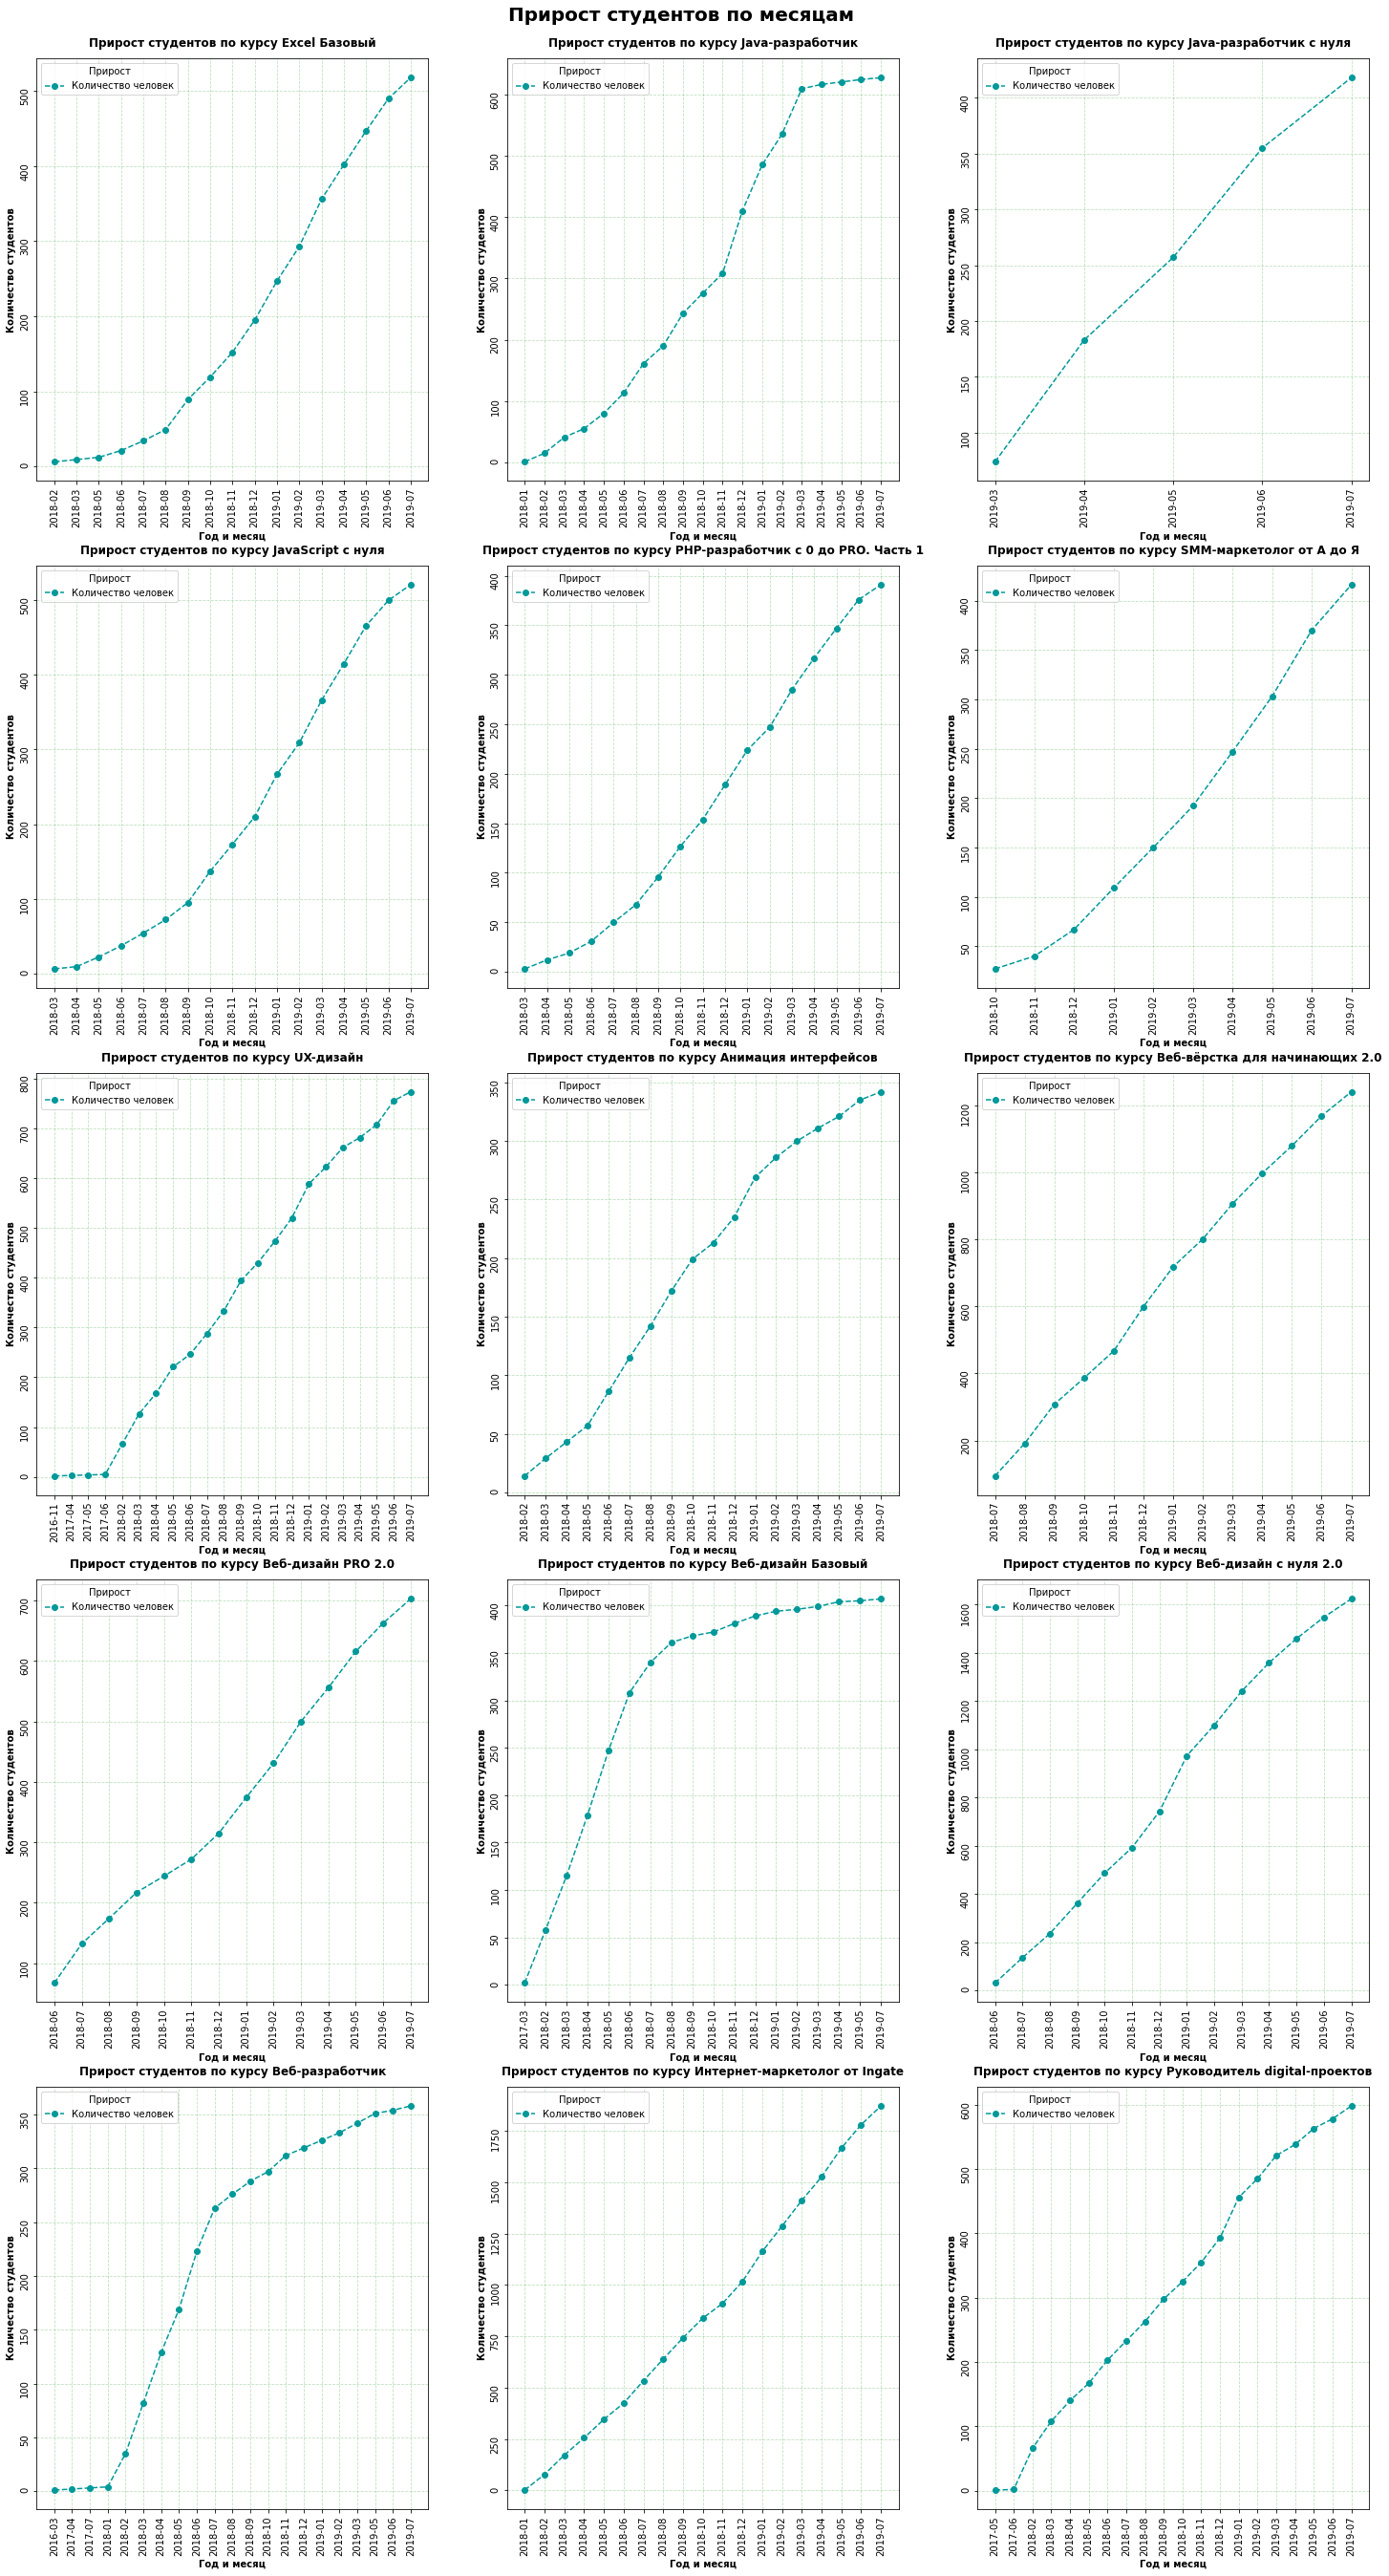

In [34]:
index = 0
fig, axes = plt.subplots(5, 3, figsize=(25,15))

for row in range(5):
    for column in range(3):
        hw_start_plot = hw_start_group[hw_start_group.course_title == hw_start_group.course_title.unique()[index]]
        data = hw_start_plot['growth']
        dates = hw_start_plot['start'].astype(str)
        axes[row, column].plot_date(dates, data, label='Количество человек', color='#009999', ls='--')
        axes[row, column].set_title('Прирост студентов по курсу {}'.format(hw_start_group.course_title.unique()[index]), fontweight = 'bold', pad = 12)
        axes[row, column].set_xlabel('Год и месяц', fontweight = 'bold')
        axes[row, column].set_ylabel('Количество студентов', fontweight = 'bold')
        axes[row, column].grid(which='major', color='#269926', linestyle='--', alpha = 0.3)
        axes[row, column].tick_params(labelrotation=90)
        axes[row, column].legend(title='Прирост')
        index += 1

plt.suptitle('Прирост студентов по месяцам', y = 2.55, fontsize=20, fontweight = 'bold')
plt.subplots_adjust(top = 2.5)                
plt.show()            

**Line-graph с несколькими линиями отражающими прирост студентов в каждом месяце для каждого курса** 


In [35]:
# сортировка куров по дате выполнения первой дз
min_date  = hw_start_group[['course_title', 'start']]
min_date.groupby(['course_title'])['start'].agg('min').sort_values()

course_title
Веб-разработчик                        2016-03
UX-дизайн                              2016-11
Веб-дизайн Базовый                     2017-03
Руководитель digital-проектов          2017-05
Java-разработчик                       2018-01
Интернет-маркетолог от Ingate          2018-01
Excel Базовый                          2018-02
Анимация интерфейсов                   2018-02
JavaScript с нуля                      2018-03
PHP-разработчик с 0 до PRO. Часть 1    2018-03
Веб-дизайн PRO 2.0                     2018-06
Веб-дизайн с нуля 2.0                  2018-06
Веб-вёрстка для начинающих 2.0         2018-07
SMM-маркетолог от А до Я               2018-10
Java-разработчик c нуля                2019-03
Name: start, dtype: period[M]

In [36]:
# группировка и заполнение пропусков нулями
hw = hw_start_group.groupby(['start', 'course_title'])['student_id'].unique().unstack(level = -1).fillna(0)
hw

course_title,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
start,,,,,,,,,,,,,,,
2016-03,0,0,0,0,0,0,0,0,0,0,0,0,[1],0,0
2016-11,0,0,0,0,0,0,[2],0,0,0,0,0,0,0,0
2017-03,0,0,0,0,0,0,0,0,0,0,[2],0,0,0,0
2017-04,0,0,0,0,0,0,[1],0,0,0,0,0,[1],0,0
2017-05,0,0,0,0,0,0,[1],0,0,0,0,0,0,0,[1]
2017-06,0,0,0,0,0,0,[1],0,0,0,0,0,0,0,[1]
2017-07,0,0,0,0,0,0,0,0,0,0,0,0,[1],0,0
2018-01,0,[1],0,0,0,0,0,0,0,0,0,0,[1],[1],0
2018-02,[6],[14],0,0,0,0,[61],[14],0,0,[56],0,[31],[76],[64]


In [97]:
# посмотрим на максимальные значения по строкам  
hw.apply(max, axis=1).sort_values(ascending=False)

start
2019-01    [231]
2018-12    [150]
2019-03    [141]
2019-05    [140]
2019-02    [127]
2018-09    [126]
2018-10    [125]
2019-04    [118]
2019-06    [114]
2018-07    [109]
2018-08    [106]
2018-11    [106]
2018-03     [94]
2019-07     [91]
2018-05     [90]
2018-04     [84]
2018-06     [79]
2018-02     [76]
2016-11      [2]
2017-03      [2]
2018-01      [1]
2017-07      [1]
2017-06      [1]
2017-05      [1]
2017-04      [1]
2016-03      [1]
Freq: M, dtype: object

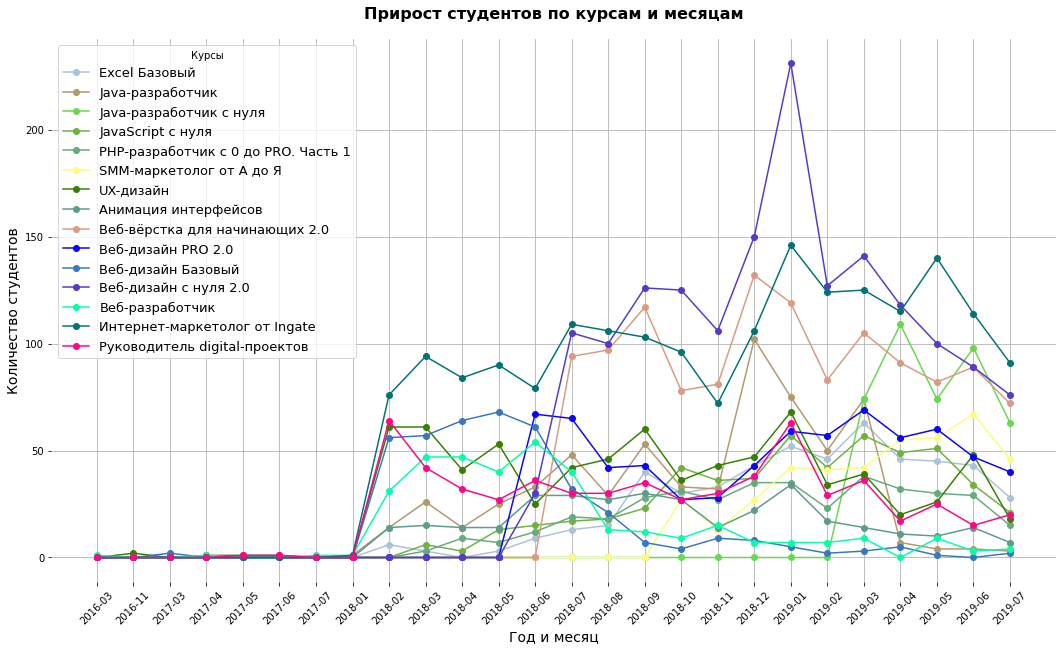

In [99]:
plt.figure(figsize=(18, 10))
colors = list(mcd.XKCD_COLORS.values()) # чтобы все линии были разноцветными, так как стандартная расцветка дублирует некоторые цвета 

counter=0
for course in hw.columns.tolist():
    plt.plot_date(hw.index.astype(str), hw[course], label = course, ls='-', color=colors[counter])
    counter += 2 # счетчик цвета 
    plt.xlabel('Год и месяц', fontsize = 14)
    plt.ylabel('Количество студентов', fontsize = 14)
    plt.xticks(rotation = 45)
    
plt.title('Прирост студентов по курсам и месяцам', fontsize = 16, fontweight = 'bold', pad=20)
plt.legend(loc=2, title='Курсы', fontsize = 13)
plt.grid()
plt.box(False)

**Расчет потенциальной нагрузки на преподавателей**

Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой (такие дз надо включать в общее число прогрессов для всех месяцев, которые покрывает срок выполнения этих дз)

In [132]:
# выбираем необходимые столбцы 
progress = summary_df[['course_title', 'progress_id', 'start_date', 'finish_date', 'is_homework']]

# удаляем строки где есть пропущенные значения и оставляем строки где есть домашнее задание
progress = progress[pd.notnull(progress['start_date']) \
                    & pd.notnull(progress['finish_date'])\
                    & (progress['is_homework'] == True)]
progress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44925 entries, 3555 to 350671
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   course_title  44925 non-null  object
 1   progress_id   44925 non-null  object
 2   start_date    44925 non-null  object
 3   finish_date   44925 non-null  object
 4   is_homework   44925 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.8+ MB


In [133]:
# изменяем тип данных в столбцах 'start_date' и 'finish_date'
progress['start_date'] = pd.to_datetime(progress['start_date'])
progress['finish_date'] = pd.to_datetime(progress['finish_date'])

# оставляем в поле только год и месяц 
progress['finish_date'] = progress['finish_date'].apply(lambda x: x.strftime('%Y-%m'))
progress['start_date'] = progress['start_date'].apply(lambda x: x.strftime('%Y-%m'))

In [134]:
# функция для определения в какой период делалось дз
def time(a, b):
    if a == b:
        return a
    else:
        return pd.date_range(a, b, freq = 'MS')

In [135]:
# делаем столбец period в котором содержится период если работа была перетекающей
# или год и месяц если работа была сделана в одном месяце
progress['period'] = progress.apply(lambda x: time(x.start_date, x.finish_date), axis = 1) 

In [136]:
# преобразуем элементы списка в строку 
progress_exp = progress.explode('period') 

In [137]:
# переводим данные столбца 'period' во временной формат и оставляем только год и месяц 
progress_exp['period'] = pd.to_datetime(progress_exp['period'])
progress_exp['period'] = progress_exp['period'].apply(lambda x: x.strftime('%Y-%m'))
progress_exp

,course_title,progress_id,start_date,finish_date,is_homework,period
3555,Веб-дизайн PRO 2.0,a387ab916f402cb3fbfffd29f68fd0ce,2018-06,2018-06,True,2018-06
3556,Веб-дизайн PRO 2.0,3b9dce04f32da32763124602557f92a3,2019-03,2019-03,True,2019-03
3557,Веб-дизайн PRO 2.0,73e17a05355852fe65b785c82c37d1ad,2019-07,2019-07,True,2019-07
3558,Веб-дизайн PRO 2.0,cc3eb34ae49c719648352c4175daee88,2018-07,2018-07,True,2018-07
3559,Веб-дизайн PRO 2.0,04ace4fe130d90c801e24eea13ee808e,2019-04,2019-04,True,2019-04
...,...,...,...,...,...,...
350656,Java-разработчик c нуля,7c46c781a54bf9d17f24b4920df4f7eb,2019-06,2019-07,True,2019-06
350656,Java-разработчик c нуля,7c46c781a54bf9d17f24b4920df4f7eb,2019-06,2019-07,True,2019-07
350657,Java-разработчик c нуля,56a9cb904c20cd2fcfa8104f87f988a7,2019-07,2019-07,True,2019-07
350670,Java-разработчик c нуля,f6216204f2c65eea37f913cfa5e4eb6a,2019-07,2019-07,True,2019-07


In [138]:
# группируем данные c подсчетом прогресса 
progress_group = progress_exp.groupby(['course_title', 'period'])['progress_id'].count().reset_index()


**Line-graph по количеству прогрессов по выполнению домашних работ в каждом месяце за всю историю для каждого курса**

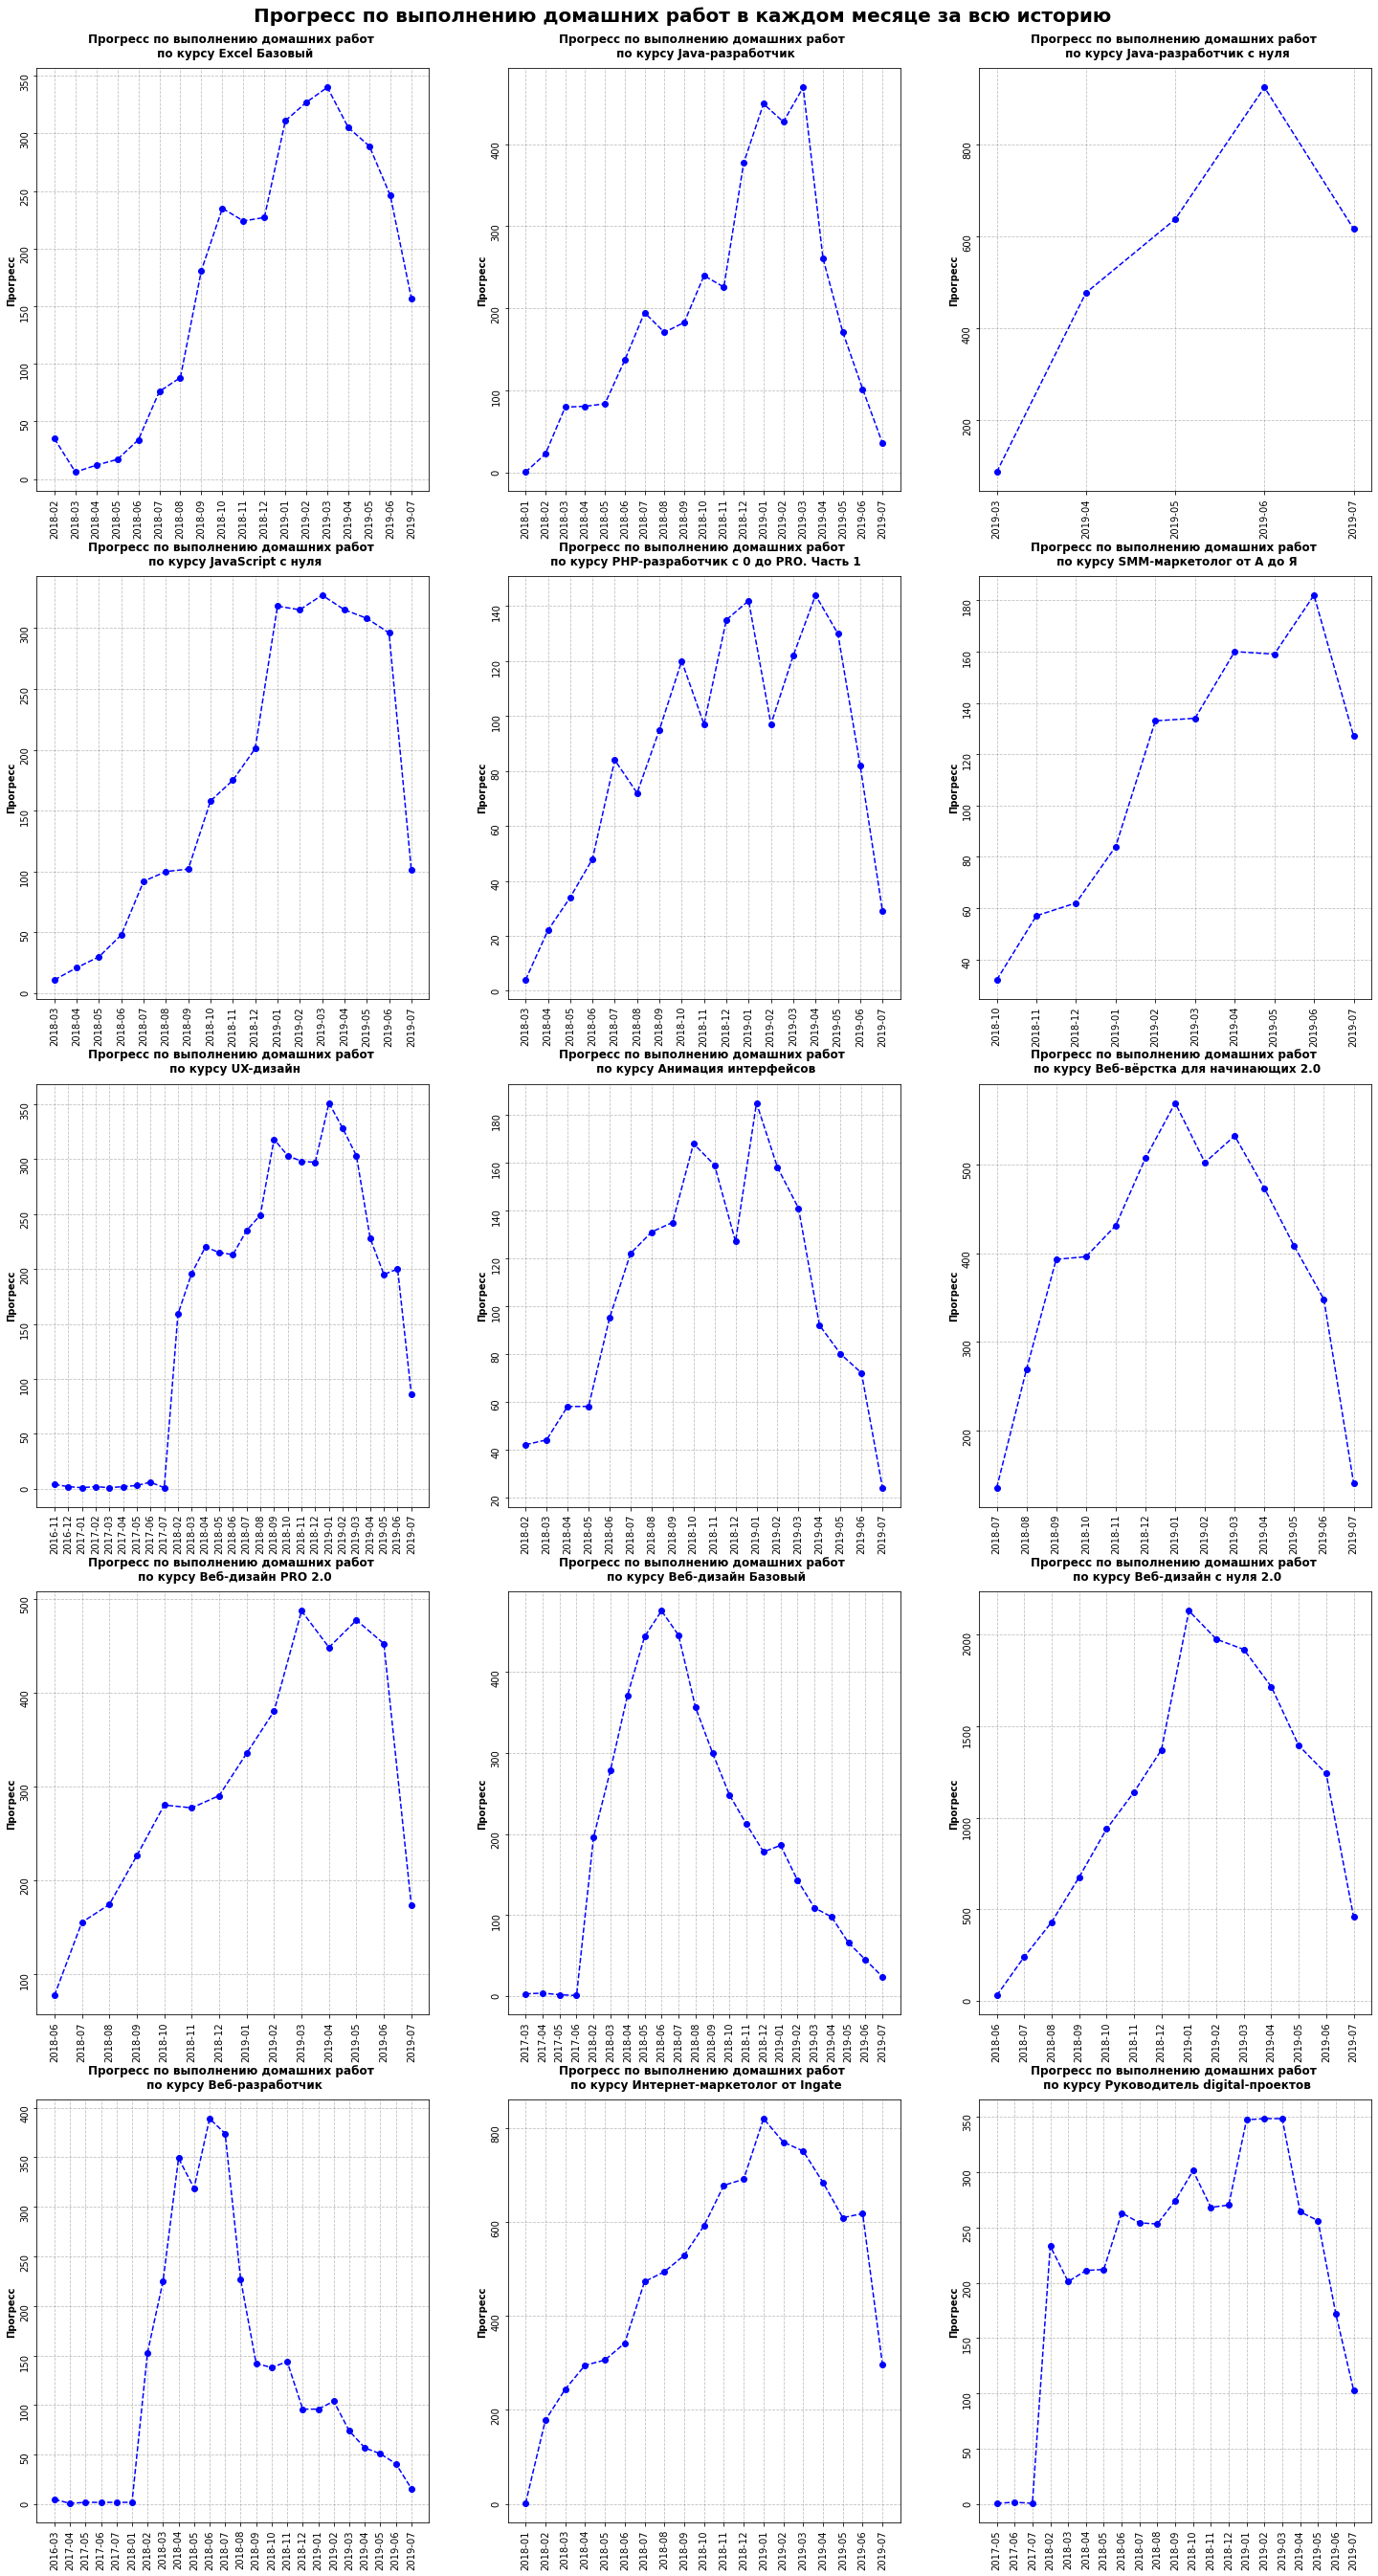

In [139]:
index = 0
fig, axes = plt.subplots(5, 3, figsize=(25, 15))

for row in range(5):
    for column in range(3):
        progress_df = progress_group[progress_group.course_title == progress_group.course_title.unique()[index]]
        data = progress_df['progress_id']
        datas = progress_df['period']
        axes[row, column].plot_date(datas, data, color='b', ls='--')
        axes[row, column].set_title(
            f'Прогресс по выполнению домашних работ \n по курсу {progress_group.course_title.unique()[index]}', fontweight='bold', pad =12)
        axes[row, column].set_ylabel('Прогресс', fontweight='bold')
        axes[row, column].tick_params(labelrotation=90)
        axes[row, column].grid(linestyle='--', color ='grey', alpha = 0.5)
        index += 1


plt.suptitle('Прогресс по выполнению домашних работ в каждом месяце за всю историю', y=2.56, fontsize=20, fontweight='bold')
plt.subplots_adjust(top=2.5)
plt.show()

**Построить один line-graph c 15ю линиями на графике** 

In [142]:
# группируем данные, изменяем форму и заполняем отсутствующие значения нулями
progress_graph = progress_exp.groupby(['period', 'course_title'])['progress_id'].count().unstack(level = -1).fillna(0)
progress_graph

course_title,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
period,,,,,,,,,,,,,,,
2016-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
2016-11,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2017-04,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0
2017-05,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0
2017-06,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0


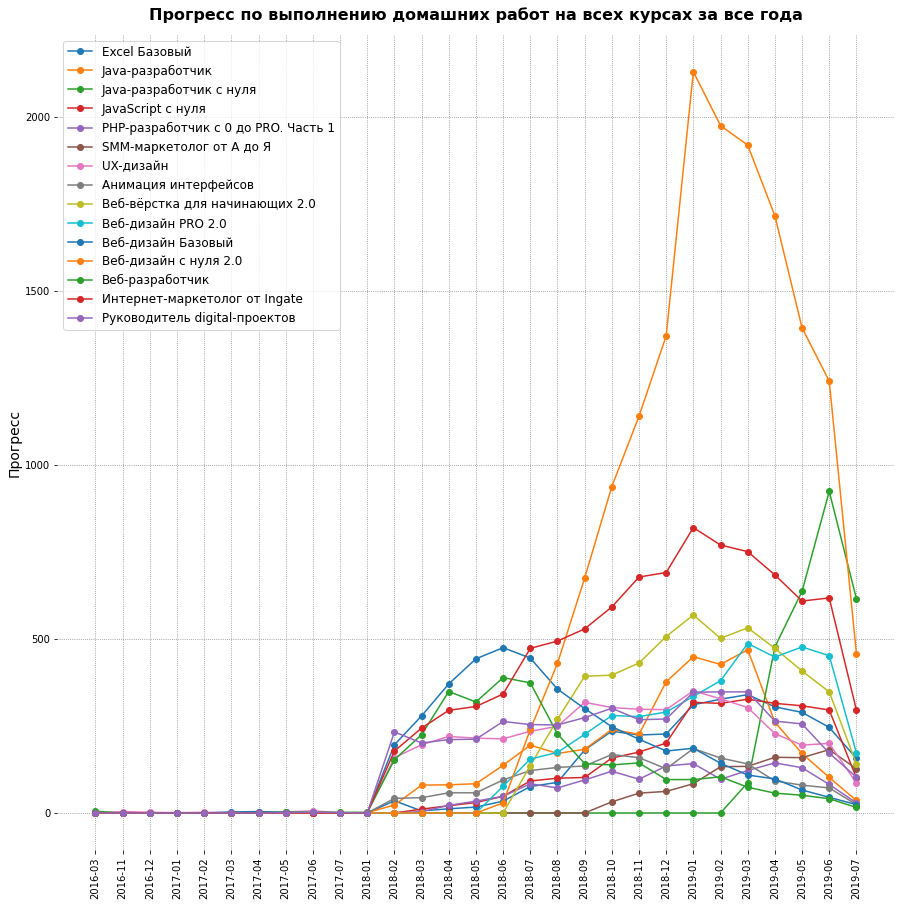

In [143]:
plt.figure(figsize = (15,15))

for course in progress_graph.columns.tolist():
    plt.plot_date(progress_graph.index, progress_graph[course], ls = '-', label = course )
    plt.xticks(rotation = 90)
    plt.title('Прогресс по выполнению домашних работ на всех курсах за все года', fontweight = 'bold', fontsize=16, pad=15)
    plt.ylabel('Прогресс', fontsize = 14)
    plt.box(False)
    plt.legend(fontsize = 12, loc = 2)
    
plt.grid(color = 'gray', linestyle = ':')
plt.show()

## Выводы по пункту 2

По всем курсам наблюдается прирост студентов, но по нескольким курсам прирост не равномерный на таких курсах как:
- «Java-разработчик» прирост студентов упал примерно в 2 раза за последние 4 месяца
- «Веб-дизайн базовый» наблюдается замедленный прирост студентов на протяжении последних 10 месяцев 
- «Веб-разработчик» прироста студентов почти не наблюдается в течении первых четырех месяцев 

На графике, где отображен прирост студентов за все время можно отметить:
- за период с марта 2016 года до января 2018 года прироста студентов почти не наблюдется. Но это наблюдение касается только курсов (таких курсов 6) где даты выполнения первого дз в пределах 03.2016-01.2018 года, так как на тот момент времени еще не началась большая часть курсов. 
- максимальный прирост студентов отмечается на курсе «Веб-дизайн с нуля 2.0»
- так же по всем курсам наблюдется снижение количества студентов в июле 2019 г.

Из графиков по нагрузке на преподавателей можно сделать вывод, что самым загруженным сезоном является весна и к середине лета нагрузка значительно снижается. 
Среди курсов есть несколько где выполнение домашних работ в начале курса практически не перетекает из месяца в месяц (то есть нагрузка на преподавателей не увеличивается), это курсы «Веб-разработчик», «UX-дизайн» и «Веб-дизайн базовый». Так же эти курсы являются по времени начала выполнения первой домашней работы самыми ранними (эти курсы были запущены раньше.


## 3. Выявление проблемных модулей

1. Рассчитать минимальное, максимальное, среднее, медианное время прохождения каждого модуля для каждого курса. Если домашних заданий в модуле несколько, то считать разность между временем начала выполнения первой домашней работы и временем окончания выполнения последней домашней работы в модуле
2. На основании первого пункта построить line-graph с медианным временем прохождения каждого модуля для каждого курса. 15 графиков.
3. Чтобы выявить сезонность, посчитать медианное время выполнения домашней работы по месяцам (12 месяцев, январь-декабрь) для каждого курса. 
4. На основании третьего пункта построить line-graph, на который будут нанесены линии для каждого курса с медианным временем выполнения домашней работы по месяцам. 15 линий на графике.
5. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

In [144]:
# выбираем необходимые столбцы 
time_df = summary_df[['course_title', 'module_number','start_date', 'finish_date','is_homework', 'status', 'student_id']]

# удаляем стоки где есть пропущенные значения, оставляем строки где есть домашнее задание и выполненный статус дз
time_df = time_df[pd.notnull(time_df['start_date']) \
                    & pd.notnull(time_df['finish_date'])\
                    & (time_df['is_homework'] == True)\
                    & (time_df['status'] == 'done')]
time_df

,course_title,module_number,start_date,finish_date,is_homework,status,student_id
3555,Веб-дизайн PRO 2.0,1,2018-06-21 19:10:36.957891+00,2018-06-28 15:59:25.320418+00,True,done,768c2987a744c51ce64a5993a2a94eaf
3556,Веб-дизайн PRO 2.0,1,2019-03-16 15:28:29.978311+00,2019-03-18 09:51:16.562395+00,True,done,03151bc73bdb29fe1be1443c6d83e22f
3557,Веб-дизайн PRO 2.0,1,2019-07-02 19:01:15.282595+00,2019-07-03 18:10:52.187797+00,True,done,ed235f47e16da6e83d3f1cb511f38ea6
3558,Веб-дизайн PRO 2.0,1,2018-07-25 09:39:56.674653+00,2018-07-27 15:39:17.61395+00,True,done,59e8681cb7b5c8043ae1aac10c8053ca
3559,Веб-дизайн PRO 2.0,1,2019-04-24 18:11:57.82383+00,2019-04-25 10:11:25.756062+00,True,done,c16250079190337fe9074736e33eecb2
...,...,...,...,...,...,...,...
350655,Java-разработчик c нуля,9,2019-06-30 12:24:44.841887+00,2019-07-01 05:11:00.227931+00,True,done,4e5f1ba884ba5759c07cf6e942ae5e98
350656,Java-разработчик c нуля,9,2019-06-29 11:22:10.230328+00,2019-07-02 20:09:44.150192+00,True,done,1a0acf593d0a38155bafdf29e3cba338
350657,Java-разработчик c нуля,9,2019-07-03 05:03:29.121944+00,2019-07-04 07:53:36.550522+00,True,done,ed93dfa830d97cf67eb047dd7a4aa181
350670,Java-разработчик c нуля,9,2019-07-01 20:06:56.697121+00,2019-07-06 04:47:43.213367+00,True,done,c21fa1f7fa61d11253e4cc8eeeb03027


**1. Рассчитать минимальное, максимальное, среднее, медианное время прохождения каждого модуля (разность между временем начала и окончания выполнения домашней работы) для каждого курса.**

In [145]:
# изменяем тип данных в столбцах с датой 
time_df[['start_date', 'finish_date']] =  time_df[['start_date', 'finish_date']].apply(pd.to_datetime)
time_df

,course_title,module_number,start_date,finish_date,is_homework,status,student_id
3555,Веб-дизайн PRO 2.0,1,2018-06-21 19:10:36.957891+00:00,2018-06-28 15:59:25.320418+00:00,True,done,768c2987a744c51ce64a5993a2a94eaf
3556,Веб-дизайн PRO 2.0,1,2019-03-16 15:28:29.978311+00:00,2019-03-18 09:51:16.562395+00:00,True,done,03151bc73bdb29fe1be1443c6d83e22f
3557,Веб-дизайн PRO 2.0,1,2019-07-02 19:01:15.282595+00:00,2019-07-03 18:10:52.187797+00:00,True,done,ed235f47e16da6e83d3f1cb511f38ea6
3558,Веб-дизайн PRO 2.0,1,2018-07-25 09:39:56.674653+00:00,2018-07-27 15:39:17.613950+00:00,True,done,59e8681cb7b5c8043ae1aac10c8053ca
3559,Веб-дизайн PRO 2.0,1,2019-04-24 18:11:57.823830+00:00,2019-04-25 10:11:25.756062+00:00,True,done,c16250079190337fe9074736e33eecb2
...,...,...,...,...,...,...,...
350655,Java-разработчик c нуля,9,2019-06-30 12:24:44.841887+00:00,2019-07-01 05:11:00.227931+00:00,True,done,4e5f1ba884ba5759c07cf6e942ae5e98
350656,Java-разработчик c нуля,9,2019-06-29 11:22:10.230328+00:00,2019-07-02 20:09:44.150192+00:00,True,done,1a0acf593d0a38155bafdf29e3cba338
350657,Java-разработчик c нуля,9,2019-07-03 05:03:29.121944+00:00,2019-07-04 07:53:36.550522+00:00,True,done,ed93dfa830d97cf67eb047dd7a4aa181
350670,Java-разработчик c нуля,9,2019-07-01 20:06:56.697121+00:00,2019-07-06 04:47:43.213367+00:00,True,done,c21fa1f7fa61d11253e4cc8eeeb03027


In [146]:
# вычисляем время выполнения домашней работы в днях 
time_df['time'] = (time_df['finish_date'] - time_df['start_date']).dt.days
time_df

,course_title,module_number,start_date,finish_date,is_homework,status,student_id,time
3555,Веб-дизайн PRO 2.0,1,2018-06-21 19:10:36.957891+00:00,2018-06-28 15:59:25.320418+00:00,True,done,768c2987a744c51ce64a5993a2a94eaf,6
3556,Веб-дизайн PRO 2.0,1,2019-03-16 15:28:29.978311+00:00,2019-03-18 09:51:16.562395+00:00,True,done,03151bc73bdb29fe1be1443c6d83e22f,1
3557,Веб-дизайн PRO 2.0,1,2019-07-02 19:01:15.282595+00:00,2019-07-03 18:10:52.187797+00:00,True,done,ed235f47e16da6e83d3f1cb511f38ea6,0
3558,Веб-дизайн PRO 2.0,1,2018-07-25 09:39:56.674653+00:00,2018-07-27 15:39:17.613950+00:00,True,done,59e8681cb7b5c8043ae1aac10c8053ca,2
3559,Веб-дизайн PRO 2.0,1,2019-04-24 18:11:57.823830+00:00,2019-04-25 10:11:25.756062+00:00,True,done,c16250079190337fe9074736e33eecb2,0
...,...,...,...,...,...,...,...,...
350655,Java-разработчик c нуля,9,2019-06-30 12:24:44.841887+00:00,2019-07-01 05:11:00.227931+00:00,True,done,4e5f1ba884ba5759c07cf6e942ae5e98,0
350656,Java-разработчик c нуля,9,2019-06-29 11:22:10.230328+00:00,2019-07-02 20:09:44.150192+00:00,True,done,1a0acf593d0a38155bafdf29e3cba338,3
350657,Java-разработчик c нуля,9,2019-07-03 05:03:29.121944+00:00,2019-07-04 07:53:36.550522+00:00,True,done,ed93dfa830d97cf67eb047dd7a4aa181,1
350670,Java-разработчик c нуля,9,2019-07-01 20:06:56.697121+00:00,2019-07-06 04:47:43.213367+00:00,True,done,c21fa1f7fa61d11253e4cc8eeeb03027,4


In [147]:
# группируем и рассчитываем показатели min, max, median по модулям
time_df.groupby(['course_title', 'module_number'])['time'].agg(['min', 'max', 'median'])

min  max  median
course_title                  module_number                  
Excel Базовый                 1               -1  183     2.0
                              2               -1  184     1.0
                              3               -1   89     1.0
                              4               -1  327     3.0
                              5               -1  175     2.5
...                                          ...  ...     ...
Руководитель digital-проектов 12              -1  211     7.0
                              13              -1  246    11.0
                              14              -1  199     7.0
                              15              -1  132     2.0
                              16              -1  355     6.0

[190 rows x 3 columns]

In [991]:
time_df_group = time_df.groupby(['course_title', 'module_number'])['time'].agg(['min', 'max', 'median']).reset_index()

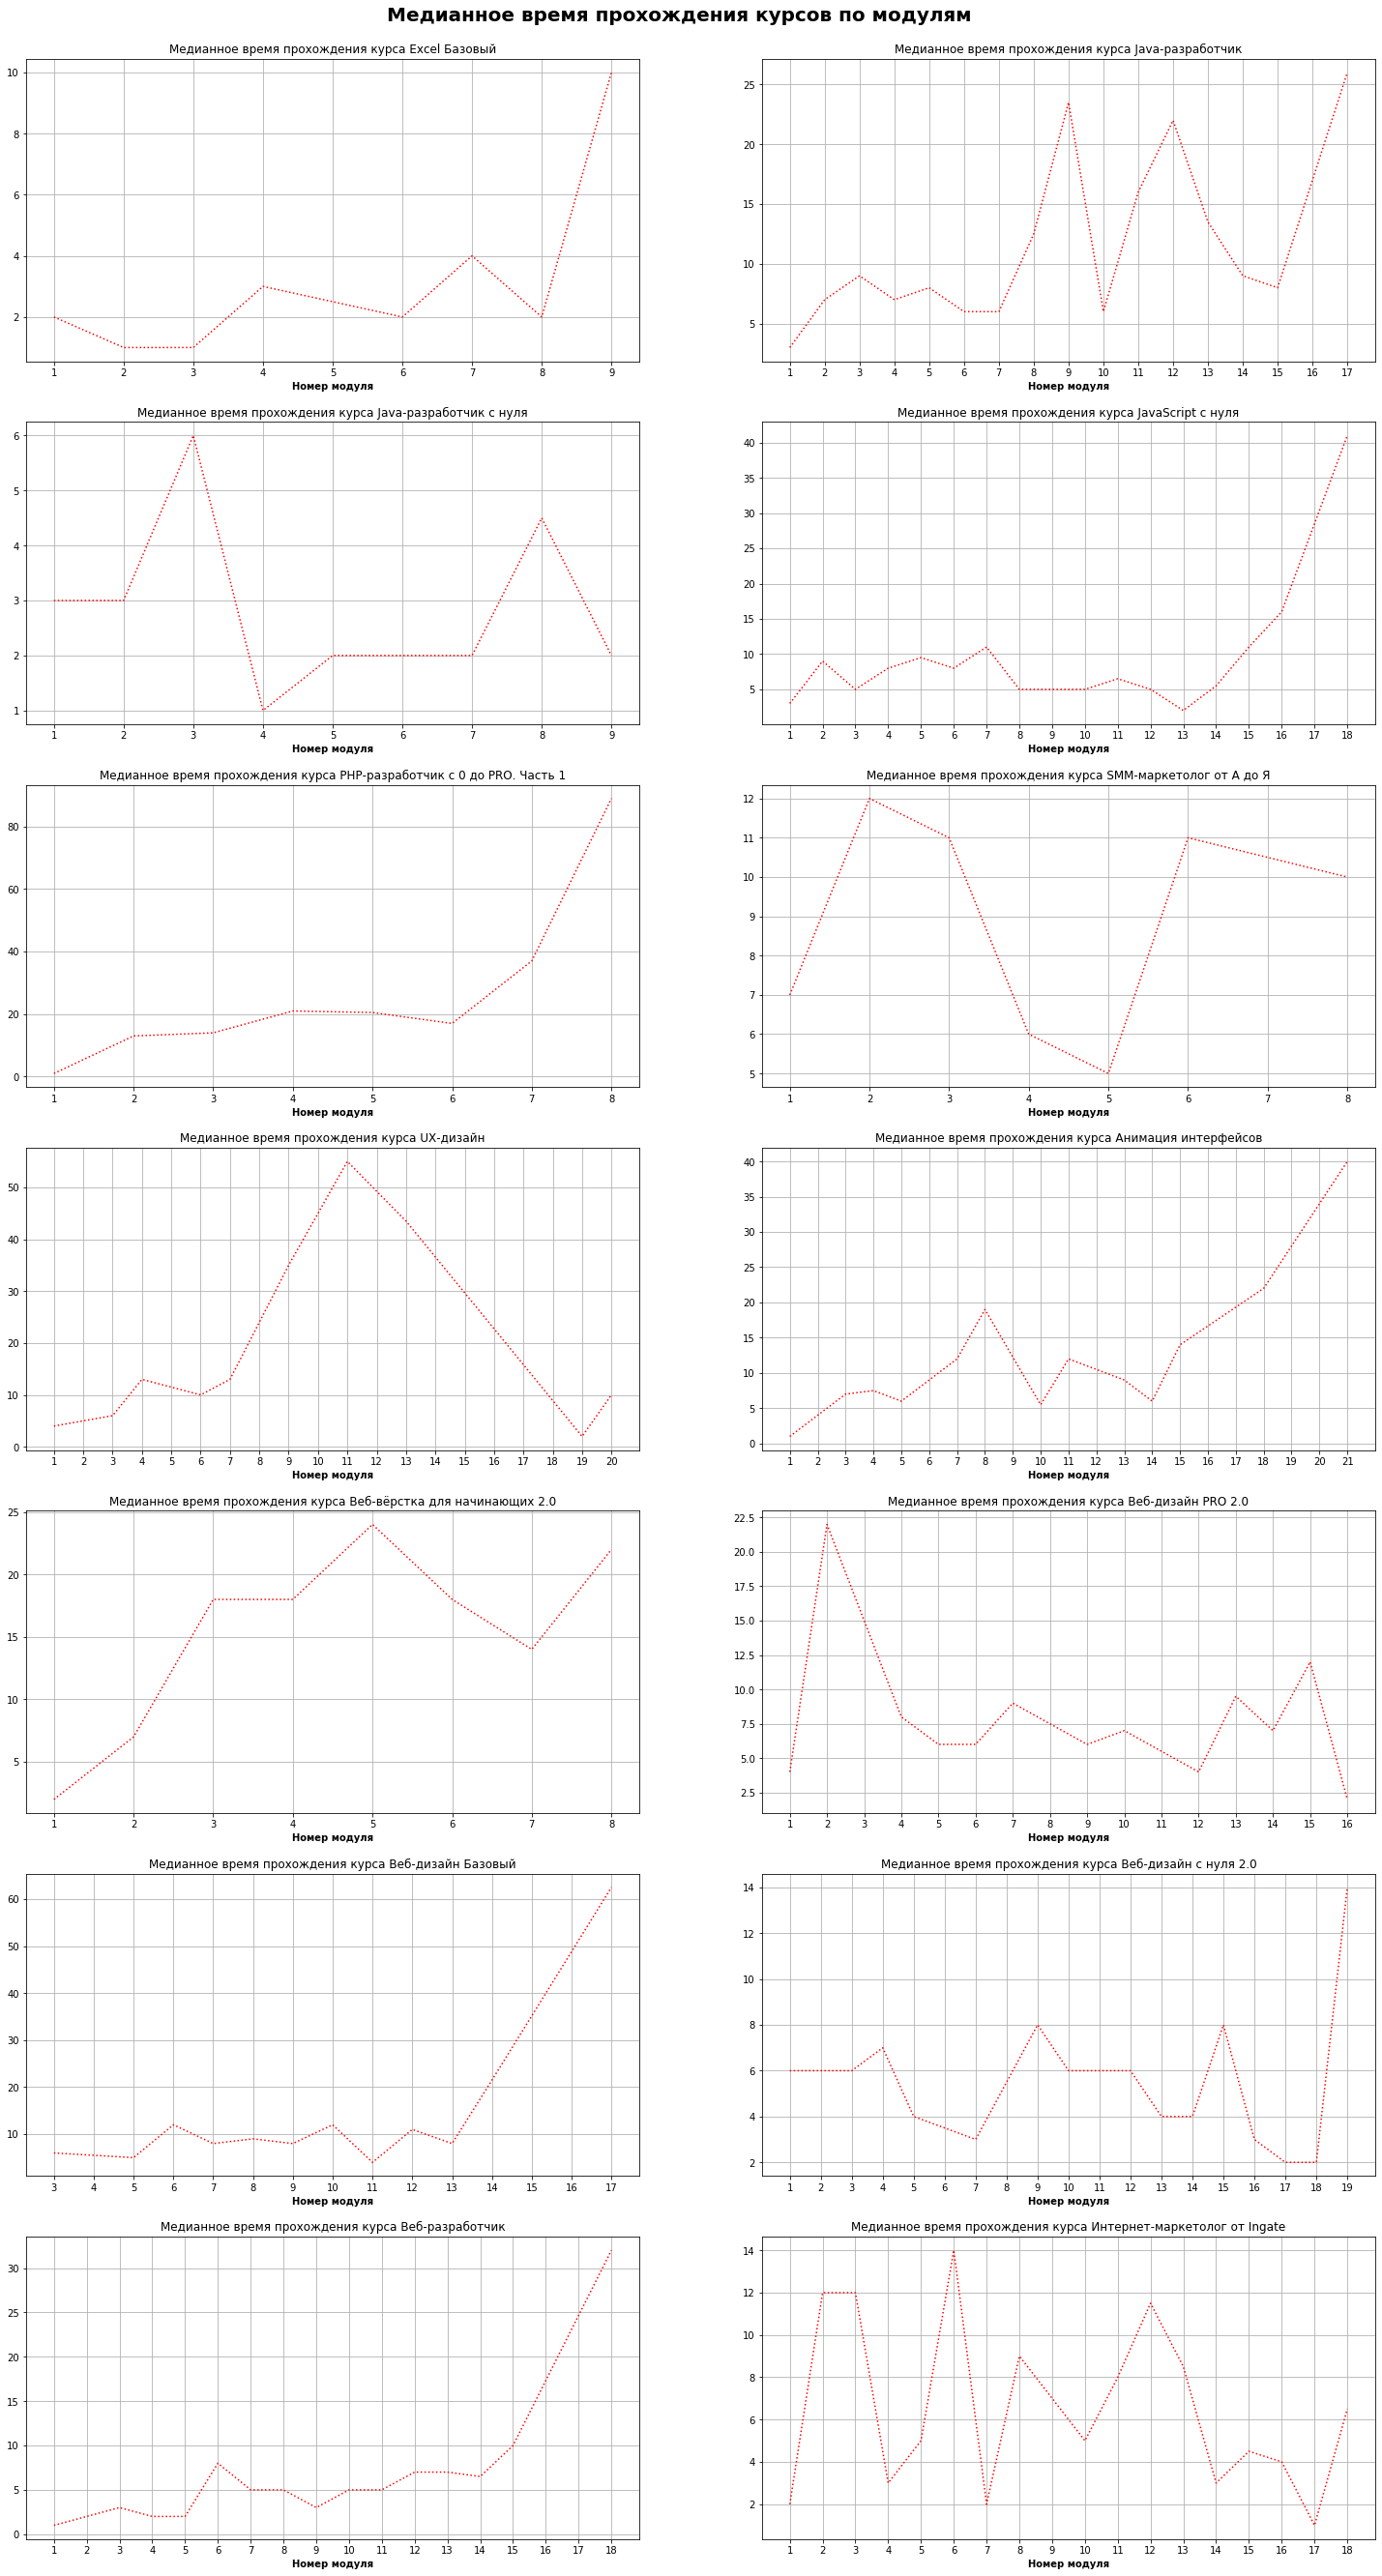

In [992]:
index = 0 
fig, axes = plt.subplots(7, 2, figsize=(25,15))

for row in range(7):
    for column in range(2):
        time_df_plot = time_df_group[time_df_group.course_title == time_df_group.course_title.unique()[index]]
        data =  time_df_plot['median']
        module = time_df_plot['module_number']
        axes[row, column].plot(module, data, label = 'Медиана', color = 'r', ls = ':')
        axes[row, column].set_title(f'Медианное время прохождения курса {time_df_group.course_title.unique()[index]}')
        axes[row, column].set_xlabel('Номер модуля', fontweight = 'bold')
        axes[row, column].set_xticks(range(math.floor(min(module)), math.ceil(max(module))+1))
        axes[row, column].grid()
        index += 1
        

plt.suptitle('Медианное время прохождения курсов по модулям', y = 2.55, fontsize=20, fontweight = 'bold')
plt.subplots_adjust(top = 2.5)                
plt.show()   

**Чтобы выявить сезонность, посчитать медианное время выполнения домашней работы по месяцам (12 месяцев, январь-декабрь) для каждого курса**
Построить line-graph, на который будут нанесены линии для каждого курса с медианным временем выполнения домашней работы по месяцам.

In [148]:
# поскольку данные за 12 месяцев есть только за 2018 год, отбираем строки где старт домашней работы в 2018 году
time_df_2018 = time_df[(time_df['start_date'].dt.year == 2018)]

In [149]:
# добавляем в дф столбец с последним месяцем выполнения дз 
time_df['month'] = time_df['finish_date'].dt.month

In [150]:
# группируем по курсам и месяцам 
time_df_2 = time_df.groupby(['course_title', 'month'])['time'].agg('median').reset_index()
time_df_2

,course_title,month,time
0,Excel Базовый,1,2.0
1,Excel Базовый,2,2.0
2,Excel Базовый,3,2.0
3,Excel Базовый,4,1.0
4,Excel Базовый,5,2.0
...,...,...,...
166,Руководитель digital-проектов,8,12.0
167,Руководитель digital-проектов,9,10.0
168,Руководитель digital-проектов,10,5.0
169,Руководитель digital-проектов,11,5.0


In [151]:
# группируем, меняем форму, пропуски заполняем нулями
time_df_2_group = time_df_2.groupby(['course_title', 'month'])['time'].unique().unstack(level = 0).fillna(0)
time_df_2_group

course_title,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
month,,,,,,,,,,,,,,,
1,[2.0],[4.5],0,[5.0],[8.0],[16.5],[10.0],[6.0],[9.0],[12.0],[11.0],[5.0],[6.0],[5.0],[5.5]
2,[2.0],[4.0],0,[6.0],[16.0],[10.0],[3.0],[3.0],[9.0],[7.0],[0.0],[6.0],[0.0],[3.0],[1.0]
3,[2.0],[5.0],[3.0],[5.0],[7.0],[11.5],[10.0],[8.0],[9.0],[7.0],[12.0],[5.0],[8.5],[5.0],[5.0]
4,[1.0],[9.0],[2.0],[4.5],[10.0],[8.5],[10.0],[4.0],[10.0],[6.0],[8.0],[4.0],[4.0],[7.0],[6.0]
5,[2.0],[13.0],[2.0],[5.0],[8.0],[8.5],[9.0],[10.0],[10.0],[5.0],[7.0],[4.0],[2.5],[7.0],[6.0]
6,[2.0],[12.0],[2.0],[6.0],[14.0],[7.0],[7.0],[4.0],[9.0],[5.0],[6.0],[4.0],[1.0],[7.0],[6.0]
7,[2.0],[6.0],[2.0],[7.0],[6.0],[7.0],[7.0],[5.0],[4.0],[8.0],[8.0],[4.0],[2.0],[5.0],[6.0]
8,[2.0],[11.0],0,[8.0],[11.0],0,[7.0],[3.0],[4.0],[24.0],[10.0],[5.0],[3.0],[5.0],[12.0]
9,[2.0],[11.0],0,[9.0],[5.0],0,[9.0],[5.0],[7.0],[24.0],[11.0],[7.0],[8.0],[4.0],[10.0]


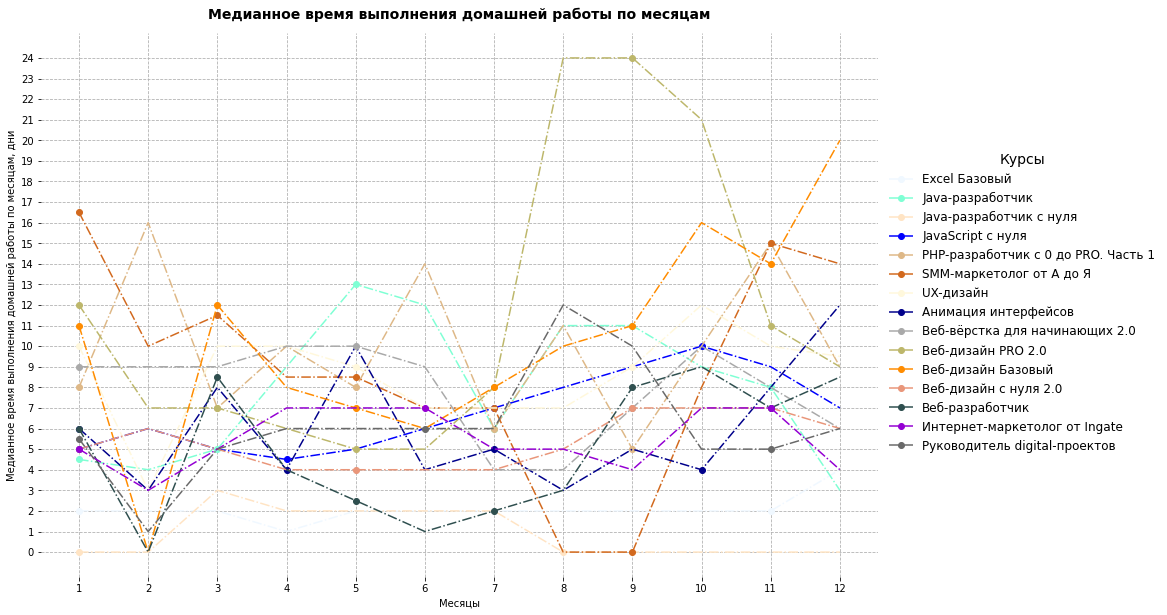

In [164]:
plt.figure(figsize = (15,10))

colors = list(mcd.CSS4_COLORS.values())

counter=0
for course in time_df_2_group.columns.tolist():
    plt.plot(time_df_2_group.index, time_df_2_group[course], label = course, color=colors[counter], ls = '-.', markevery= int(time_df_2_group[course].value_counts().nlargest(n=1)), marker='o')
    counter += 3
    plt.title('Медианное время выполнения домашней работы по месяцам', fontsize = 14, fontweight='bold', pad = 15)
    plt.xlabel('Месяцы')
    plt.ylabel('Медианное время выполнения домашней работы по месяцам, дни')
    plt.xticks(range(1,13))
    plt.yticks(range(0,int(time_df_2_group.max().sort_values(ascending = False)[0])+1))
    plt.legend(bbox_to_anchor=(1, 0.8), frameon=False, title = 'Курсы', fontsize = 12, title_fontsize =14)
    plt.box(on=None)
    plt.grid(linestyle='--')
    

In [165]:
# топ-3 курсов по медиане выполнения дз
# выберем по 3 курса в сезоне в которых медиана выполнения дз самая высокая. [[11,0,1]] - номера месяцев
winter = time_df_2_group.iloc[[11,0,1]].max().sort_values(ascending = False)[:3].reset_index()
winter.rename(columns = {'course_title':'winter', 0:'median'}, inplace = True)

spring = time_df_2_group.iloc[[2,3,4]].max().sort_values(ascending = False)[:3].reset_index()
spring.rename(columns = {'course_title':'spring', 0:'median'}, inplace = True)

summer = time_df_2_group.iloc[[5,6,7]].max().sort_values(ascending = False)[:3].reset_index()
summer.rename(columns = {'course_title':'summer', 0:'median'}, inplace = True)

autumn = time_df_2_group.iloc[[8,9,10]].max().sort_values(ascending = False)[:3].reset_index()
autumn.rename(columns = {'course_title':'autumn', 0:'median'}, inplace = True)

In [168]:
# объединим сезоны и их топ-3
pd.concat([winter, spring, summer, autumn], axis=1)

,winter,median,spring,median,summer,median,autumn,median
0,Веб-дизайн Базовый,[20.0],Java-разработчик,[13.0],Веб-дизайн PRO 2.0,[24.0],Веб-дизайн PRO 2.0,[24.0]
1,SMM-маркетолог от А до Я,[16.5],Веб-дизайн Базовый,[12.0],PHP-разработчик с 0 до PRO. Часть 1,[14.0],Веб-дизайн Базовый,[16.0]
2,PHP-разработчик с 0 до PRO. Часть 1,[16.0],SMM-маркетолог от А до Я,[11.5],Java-разработчик,[12.0],PHP-разработчик с 0 до PRO. Часть 1,[15.0]


In [192]:
# рассчитаем медиану по всем курсам и сезонам 
# медиана по всем курсам за зиму 
print('Зима', round((time_df_2_group.iloc[[11,0,1]].sum().sum()/15)[0],2))
# медиана по всем курсам за весну
print('Весна', round((time_df_2_group.iloc[[2,3,4]].sum().sum()/15)[0],2))
# медиана по всем курсам за лето
print('Лето', round((time_df_2_group.iloc[[5,6,7]].sum().sum()/15)[0],2))
# медиана по всем курсам за осень
print('Осень', round((time_df_2_group.iloc[[8,9,10]].sum().sum()/15)[0],2))

Зима 19.57
Весна 19.73
Лето 18.4
Осень 24.53


## Выводы по пункту 3
По данным о времени прохождения курсов заметны аномалии в графе с максимальным значением времени прохождения модуля, поэтому если работа выполняется долго (более 2х месяцев), но при этом она выполнена, считаем, что она была сделана в последнем месяце. 

Из всех графиков, на которых изображено медианное время прохождения модулей можно заметить, что к концу курса медианное время выполнения домашних работ возрастает, кроме курсов «Разработчик Java с нуля», «SMM-маркетолог от А до Я», «Веб-дизайн PRO 2.0». 

Из медианы прохождения всех курсов по сезонам можно сделать вывод, что время выполнения работ имеет сезонность самая низкая медиана летом, а самая высокая - осенью. 

Из объединенной таблицы по сезонам видно, что дольше всего делают дз на курсах "Веб-дизайн Базовый", "Веб-дизайн PRO 2.0" и "SMM-маркетолог от А до Я"

## 4. Расчет конверсии

1. Посчитать конверсию перехода студентов из одного модуля в другой на каждом курсе. 
2. Постройте bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе.
3. Постройте горизонтальныйbar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. 15 графиков.
4. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

In [193]:
summary_df.head()

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
1,3b9dce04f32da32763124602557f92a3,2,4,done,2019-03-18 14:23:17.328374+00,2019-03-18 14:54:50.979612+00,03151bc73bdb29fe1be1443c6d83e22f,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
2,73e17a05355852fe65b785c82c37d1ad,2,4,done,2019-07-09 09:18:46.19862+00,2019-07-11 08:03:09.222385+00,ed235f47e16da6e83d3f1cb511f38ea6,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
3,cc3eb34ae49c719648352c4175daee88,2,4,done,2018-07-27 15:39:17.666629+00,2018-07-27 16:13:55.086871+00,59e8681cb7b5c8043ae1aac10c8053ca,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False
4,04ace4fe130d90c801e24eea13ee808e,2,4,done,2019-04-24 18:42:40.272854+00,2019-04-24 18:44:57.507857+00,c16250079190337fe9074736e33eecb2,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False


In [194]:
# выбираем нужные столбцы фильтруем по домашней работе  
first_hw = summary_df[summary_df['is_homework'] == True]\
        .groupby(['field','course_title','module_number','student_id'])['start_date'].min().reset_index()
first_hw

,field,course_title,module_number,student_id,start_date
0,Business,Excel Базовый,1,001b192f899a84496be98b41906246fc,2019-03-29 20:43:08.914029+00
1,Business,Excel Базовый,1,006f0189ec657741ee4d53474c7a258d,2019-01-25 03:25:26.690241+00
2,Business,Excel Базовый,1,0074621b6955733338ab0feb2a9a2100,2019-04-10 14:09:35.364174+00
3,Business,Excel Базовый,1,0098ca12f73a56dadbf6099389305d80,2019-04-03 11:06:03.164368+00
4,Business,Excel Базовый,1,0203a4ab8610441e866932fb899ed583,2019-05-08 16:24:20.71068+00
...,...,...,...,...,...
52772,Marketing,Интернет-маркетолог от Ingate,18,f15d37b4cc4223187d643dbab0f7bb11,2019-05-25 21:08:37.93588+00
52773,Marketing,Интернет-маркетолог от Ingate,18,f1ee750ba369f122982ef490869a1617,2019-05-17 22:36:04.815586+00
52774,Marketing,Интернет-маркетолог от Ingate,18,f436ff956a32b08a37585a4f6dfa733b,2019-04-20 10:55:24.306156+00
52775,Marketing,Интернет-маркетолог от Ingate,18,f67c207ae492c7b0e1bd2dd719980594,2019-05-03 14:40:56.051436+00


In [195]:
# подсчитываем количество студентов, которые начали выполнять дз в каждом модуле и на каждом курсе 
first_hw = first_hw.groupby(['field','course_title','module_number'])['student_id'].count().reset_index()
first_hw.head(3)

,field,course_title,module_number,student_id
0,Business,Excel Базовый,1,518
1,Business,Excel Базовый,2,434
2,Business,Excel Базовый,3,398


In [196]:
# выбираем столбцы где есть дз, и статус домашней работы done 
last_hw = summary_df[(summary_df['is_homework'] == True) & (summary_df['status'] == 'done')]\
        .groupby(['field','course_title','module_number','student_id'])['finish_date'].max().reset_index()

In [197]:
# подсчитываем количество студентов, которые выполнили дз в каждом модуле и на каждом курсе 
last_hw = last_hw.groupby(['field','course_title','module_number'])['student_id'].count().reset_index()

last_hw.head(3)

,field,course_title,module_number,student_id
0,Business,Excel Базовый,1,458
1,Business,Excel Базовый,2,406
2,Business,Excel Базовый,3,387


In [198]:
# соединяем дф 
conversion = first_hw.merge(last_hw, how='left', on=['course_title', 'module_number'])
conversion.rename(columns = {'student_id_x':'started', 'student_id_y':'finished', 'field_x':'field'}, inplace=True)
conversion.drop(['field_y'], axis='columns', inplace = True)

conversion.head(5)

,field,course_title,module_number,started,finished
0,Business,Excel Базовый,1,518,458.0
1,Business,Excel Базовый,2,434,406.0
2,Business,Excel Базовый,3,398,387.0
3,Business,Excel Базовый,4,345,303.0
4,Business,Excel Базовый,5,298,270.0


In [199]:
# сдвигаем столбец finished на одну строку, так что бы можно было удобнее вычислить конверсию по строкам 
conversion['finished'] = conversion['finished'].shift(1)
conversion.head(3)

,field,course_title,module_number,started,finished
0,Business,Excel Базовый,1,518,NaN
1,Business,Excel Базовый,2,434,458.0
2,Business,Excel Базовый,3,398,406.0


In [200]:
# рассчитываем конверсию и округляем до 2х знаков после запятой 
conversion['conv'] = ((conversion['started'] / conversion['finished']) * 100).round(2)
conversion.head()

,field,course_title,module_number,started,finished,conv
0,Business,Excel Базовый,1,518,NaN,NaN
1,Business,Excel Базовый,2,434,458.0,94.76
2,Business,Excel Базовый,3,398,406.0,98.03
3,Business,Excel Базовый,4,345,387.0,89.15
4,Business,Excel Базовый,5,298,303.0,98.35


In [201]:
# так как для первого модуля конверсию посчитать нельзя 
# присваиваем значение равное 100% в каждом модуле с номером 1
conversion.conv[conversion.module_number == 1] = 100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
# посмотрим на значения конверсии и ужаснемся 
conversion['conv'].sort_values(ascending = False)

64     1071.05
171     505.56
136     130.77
165     130.30
170     121.74
        ...   
116      60.71
169      56.44
190      45.90
45        8.57
46         NaN
Name: conv, Length: 191, dtype: float64

In [203]:
# отсечем значения по верхнему квантилю
q = conversion["conv"].quantile(0.99)
conversion = conversion[conversion["conv"] < q]

In [204]:
# изменяем форму таблицы для построения 
conversion.pivot('module_number', 'course_title', 'conv')

course_title,Excel Базовый,Java-разработчик,Java-разработчик c нуля,JavaScript с нуля,PHP-разработчик с 0 до PRO. Часть 1,SMM-маркетолог от А до Я,UX-дизайн,Анимация интерфейсов,Веб-вёрстка для начинающих 2.0,Веб-дизайн PRO 2.0,Веб-дизайн Базовый,Веб-дизайн с нуля 2.0,Веб-разработчик,Интернет-маркетолог от Ingate,Руководитель digital-проектов
module_number,,,,,,,,,,,,,,,
1,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,NaN,100.00,100.00,100.00,100.00
2,94.76,92.54,98.59,95.00,85.53,81.82,97.38,98.19,92.50,94.64,NaN,NaN,98.38,91.26,95.89
3,98.03,87.59,95.48,98.44,130.77,94.83,98.56,99.08,99.14,NaN,NaN,100.29,98.88,90.59,107.20
4,89.15,96.26,108.00,99.08,102.40,56.44,100.25,104.86,102.39,101.52,NaN,98.85,91.74,107.17,97.10
5,98.35,93.10,70.20,104.49,113.75,121.74,NaN,93.33,103.36,89.04,95.48,98.00,115.61,95.37,104.91
6,97.41,101.16,73.27,99.32,105.56,NaN,96.30,NaN,108.12,97.86,99.07,NaN,91.71,92.90,99.53
7,98.35,98.75,80.00,100.00,98.18,NaN,99.25,94.85,105.04,102.05,98.56,98.03,101.96,114.79,98.50
8,101.00,95.77,67.35,98.08,119.44,96.92,NaN,98.59,107.45,NaN,100.00,NaN,98.44,97.98,102.60
9,102.69,105.66,60.71,98.92,NaN,NaN,101.41,NaN,NaN,95.88,99.14,99.26,105.56,100.00,101.49


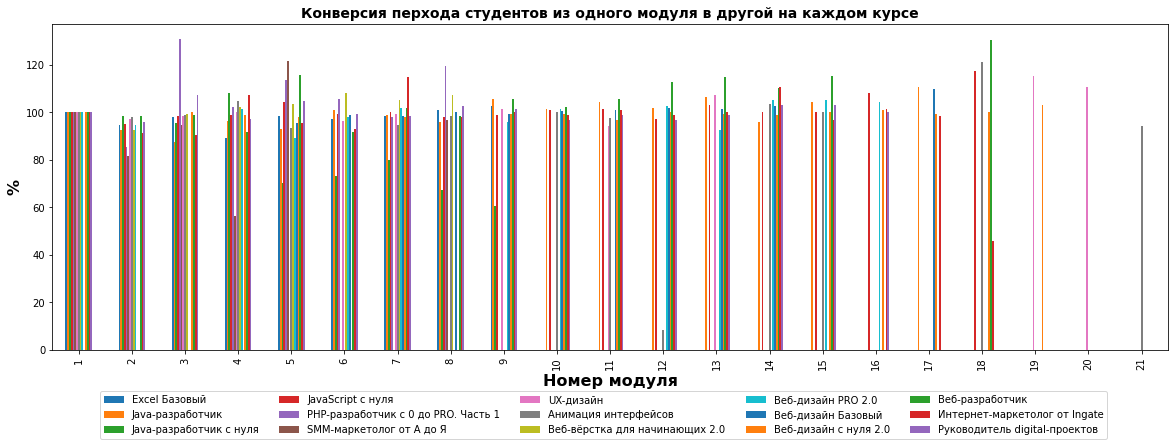

In [205]:
conversion.pivot('module_number', 'course_title', 'conv').plot(kind='bar',figsize=(20,6))
plt.title('Конверсия перхода студентов из одного модуля в другой на каждом курсе', fontsize = 14, fontweight = 'bold')
plt.ylabel('%', fontweight = 'bold', fontsize = 16)
plt.xlabel('Номер модуля', fontweight = 'bold', fontsize = 16)
plt.legend(bbox_to_anchor = (0.95, -0.11), ncol = 5)
plt.show()

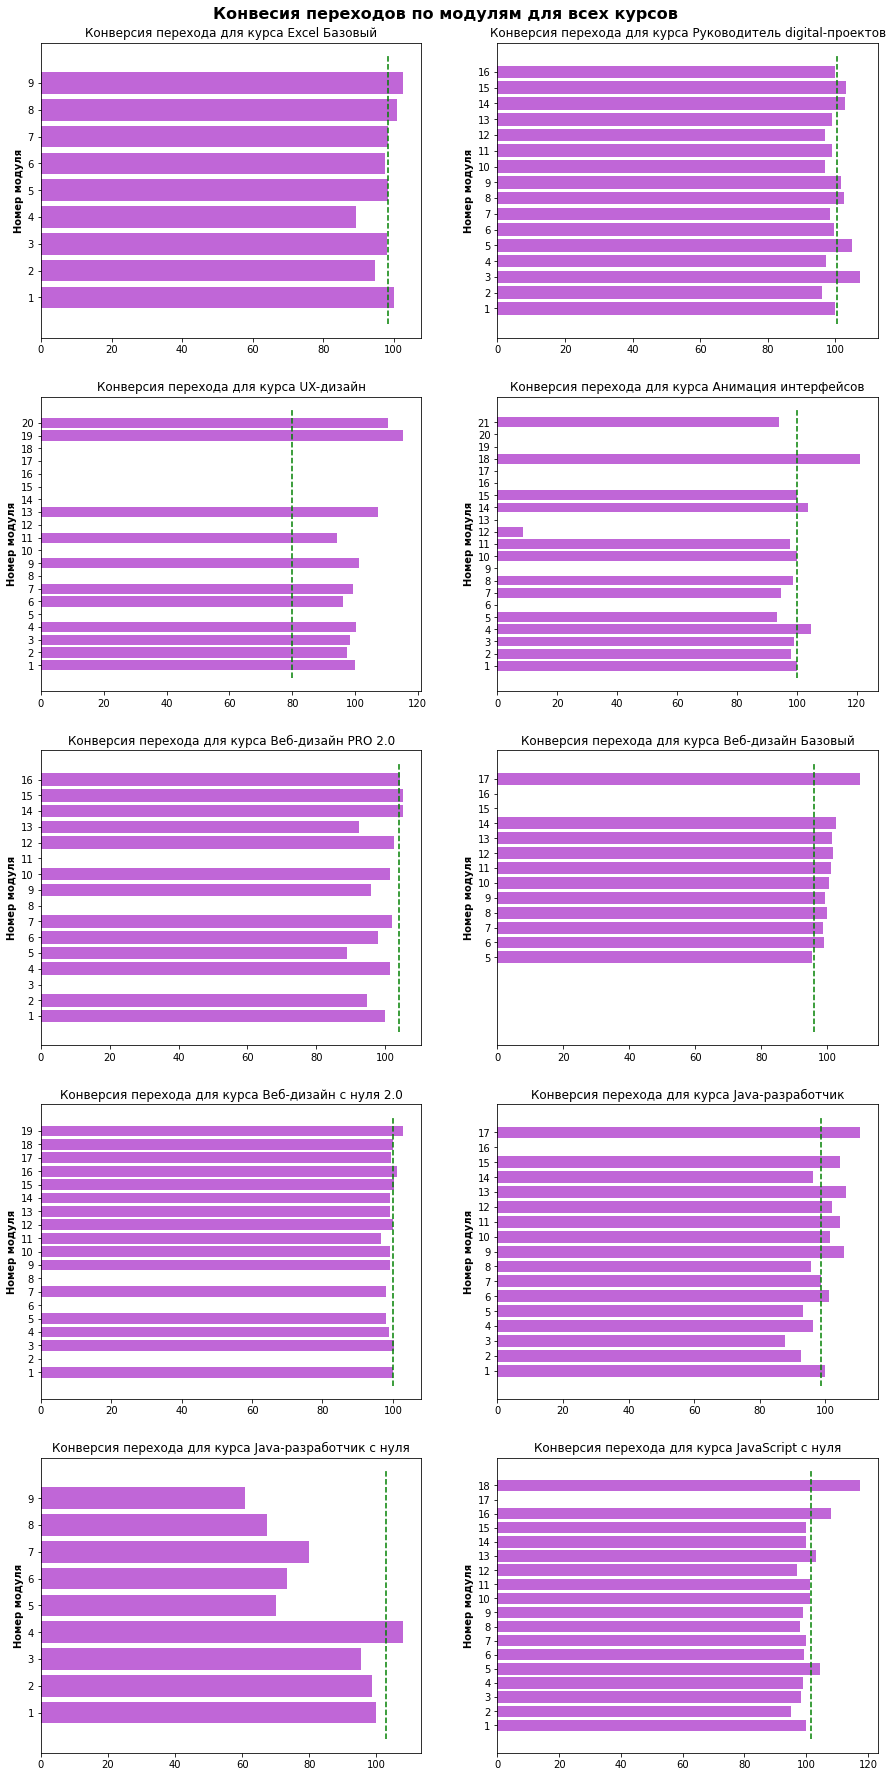

In [240]:
index = 0 
fig, axes = plt.subplots(5, 2, figsize=(15,10))

for row in range(5):
    for column in range(2):
        conversion_plot = conversion[conversion.course_title == conversion.course_title.unique()[index]]
        data =  conversion_plot['conv']
        module = conversion_plot['module_number']
        axes[row, column].barh(module, data, color = 'mediumorchid', alpha = 0.9)
        axes[row, column].set_title(f'Конверсия перехода для курса {conversion.course_title.unique()[index]}')
        axes[row, column].vlines(conversion.groupby(['course_title'])['conv'].agg('median')[index], \
                                 ls='--', color='g', ymin=0, ymax=math.ceil(max(module))+1)
        axes[row, column].set_ylabel('Номер модуля', fontweight = 'bold')
        axes[row, column].set_yticks(range(math.floor(min(module)), math.ceil(max(module))+1))
        
        index += 1
        

plt.suptitle('Конверсия переходов по модулям для всех курсов', y = 2.55, fontsize=16, fontweight = 'bold')
plt.subplots_adjust(top = 2.5)
plt.show() 

In [207]:
# медиана конверсии по всем курсам 
conv_median = conversion.groupby('course_title')['conv'].agg('median')\
    .reset_index().sort_values(by = 'conv', ascending = False)

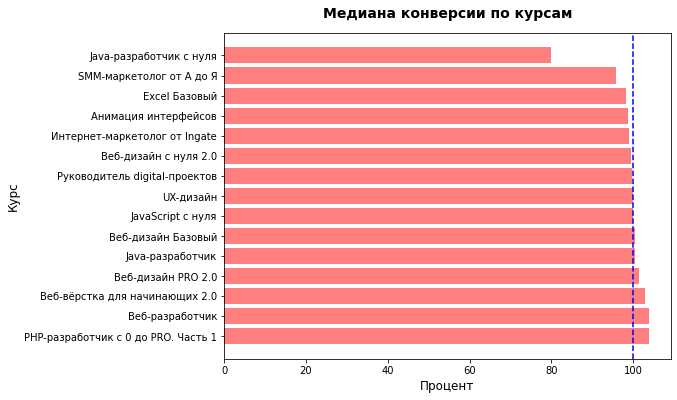

In [216]:
x = conv_median['course_title']
y = conv_median['conv']

plt.subplots(figsize=(8,6))

plt.barh(x,y, color = 'r', alpha = 0.5)
plt.axvline(x = conv_median['conv'].agg('median'), ls='--', color='b')
plt.title('Медиана конверсии по курсам', fontweight = 'bold', fontsize = 14, pad = 15)
plt.ylabel('Курс', fontsize = 12)
plt.xlabel('Процент', fontsize = 12)
plt.show()

In [211]:
# медианная конверсия по сферам 
conversion.groupby('field')['conv'].agg('median').reset_index().sort_values(by = 'conv', ascending = False)

,field,conv
1,Design,100.000
2,Development,100.000
0,Business,99.070
3,Marketing,98.675


## Выводы по пункту 4 
Расчет медианы конверсии по курсам и сферам показал:
- медиана конверсии по сферам практисчески одинаковая
- самый низкий показатель медианы на курсах "Java-разработчик c нуля" и "SMM-маркетолог от А до Я"
- по сферам медиана конверсии выше 98%, максимальное значение в сфере Дизайна и Разработки

## 5. Метрика успеваемости 

&nbsp;&nbsp;&nbsp;&nbsp;*(необязательное задание)*

Иногда студенты берут курсы, которые оказываются для них неподъемными. Это может быть как по причинам недостаточной изначальной подготовки, так и по причинам, связанным с низкой мотивацией студента. Для улучшения качества контента полезно выявить причину. На основании имеющихся данных придумайте метрику успеваемости студента. **Обоснуйте ее.** Выявите таких студентов на каждом курсе, чтобы предоставить продюсерам список проблемных студентов. 

In [217]:
# отберем записи где есть дз
a = summary_df[(summary_df['is_homework'] == True)]
a.head()

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework
3555,a387ab916f402cb3fbfffd29f68fd0ce,1,6,done,2018-06-21 19:10:36.957891+00,2018-06-28 15:59:25.320418+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3556,3b9dce04f32da32763124602557f92a3,1,6,done,2019-03-16 15:28:29.978311+00,2019-03-18 09:51:16.562395+00,03151bc73bdb29fe1be1443c6d83e22f,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3557,73e17a05355852fe65b785c82c37d1ad,1,6,done,2019-07-02 19:01:15.282595+00,2019-07-03 18:10:52.187797+00,ed235f47e16da6e83d3f1cb511f38ea6,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3558,cc3eb34ae49c719648352c4175daee88,1,6,done,2018-07-25 09:39:56.674653+00,2018-07-27 15:39:17.61395+00,59e8681cb7b5c8043ae1aac10c8053ca,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3559,04ace4fe130d90c801e24eea13ee808e,1,6,done,2019-04-24 18:11:57.82383+00,2019-04-25 10:11:25.756062+00,c16250079190337fe9074736e33eecb2,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True


In [218]:
# переведем во временной формат столбцы старта и финиша 
a[['start_date', 'finish_date']] =  a[["start_date", "finish_date"]].apply(pd.to_datetime)
# оставим только год и месяц 
a['start_date'] = a['start_date'].apply(lambda x: x.strftime('%Y-%m'))
a['finish_date'] = a['finish_date'].apply(lambda x: x.strftime('%Y-%m'))
a.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework
3555,a387ab916f402cb3fbfffd29f68fd0ce,1,6,done,2018-06,2018-06,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3556,3b9dce04f32da32763124602557f92a3,1,6,done,2019-03,2019-03,03151bc73bdb29fe1be1443c6d83e22f,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3557,73e17a05355852fe65b785c82c37d1ad,1,6,done,2019-07,2019-07,ed235f47e16da6e83d3f1cb511f38ea6,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3558,cc3eb34ae49c719648352c4175daee88,1,6,done,2018-07,2018-07,59e8681cb7b5c8043ae1aac10c8053ca,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True
3559,04ace4fe130d90c801e24eea13ee808e,1,6,done,2019-04,2019-04,c16250079190337fe9074736e33eecb2,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True


In [219]:
# вычислим разницу в днях на выполнение дз
a[['start_date', 'finish_date']] =  a[["start_date", "finish_date"]].apply(pd.to_datetime)
a['days'] = a['finish_date'] - a['start_date']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [221]:
# установим предел выполнения дз 60 дней (произвольная цифра)
hw = a[(a['days'] >= '60 days') | (a['status'] != 'done')]
# посмотрим на значения в столбце 
hw['days'].value_counts()

61 days     1141
92 days      388
62 days      229
122 days     147
90 days      140
120 days     137
91 days      137
151 days      94
89 days       93
153 days      86
123 days      66
212 days      54
181 days      43
121 days      43
182 days      32
243 days      30
184 days      30
214 days      21
150 days      20
242 days      18
304 days      18
337 days      15
245 days      15
273 days      14
183 days      13
365 days      13
215 days      13
303 days      10
306 days       9
274 days       8
334 days       7
335 days       5
457 days       4
276 days       4
395 days       3
244 days       3
275 days       3
396 days       3
426 days       3
454 days       1
424 days       1
393 days       1
456 days       1
487 days       1
Name: days, dtype: int64

In [222]:
# подсчитаем значения в колонке где дз True  
# так как встречаются такие названия как "Экзаменационная работа", "Курсовая работа" и д.р.
hw['lesson_title'].value_counts()

Домашняя работа                   11661
Экзаменационная работа              285
Домашнее задание                    196
Домашняя работа (первая часть)      149
Домашнее задание #1                  85
Домашнее задание #2                  69
Курсовая работа                      41
Домашняя работа (вторая часть)       34
Дипломный проект без заказчика       19
Домашняя работа 4.5                  16
Финальное тестирование               14
Дипломная работа                     13
Домашняя работа 4.4                  13
Домашняя работа 4.3                  11
Домашняя работа 4.1                  11
Домашняя работа 5.2                  10
Домашняя работа 5.4                  10
Домашняя работа 5.5                   9
Домашняя работа 5.3                   8
Домашняя работа 4.6                   6
Домашняя работа 4.2                   5
Домашняя работа 5.1                   5
Name: lesson_title, dtype: int64

In [223]:
# оставим записи с домашними работами
hw = hw[(hw['lesson_title'].str.contains("Домашняя", case=False))]

In [224]:
# проверим. Посмотрим на значения столбца
hw['lesson_title'].value_counts()

Домашняя работа                   11661
Домашняя работа (первая часть)      149
Домашняя работа (вторая часть)       34
Домашняя работа 4.5                  16
Домашняя работа 4.4                  13
Домашняя работа 4.1                  11
Домашняя работа 4.3                  11
Домашняя работа 5.4                  10
Домашняя работа 5.2                  10
Домашняя работа 5.5                   9
Домашняя работа 5.3                   8
Домашняя работа 4.6                   6
Домашняя работа 4.2                   5
Домашняя работа 5.1                   5
Name: lesson_title, dtype: int64

In [225]:
# проверим какие значения столбца по статусам остались 
hw.status.value_counts()

start    6158
done     2946
fail     2628
wait      216
Name: status, dtype: int64

In [226]:
# отберем записи где статус дз не 'выполнено'. 
# Так как не успеваемость можно оценить только по тем записям где оно не сделано 
hw = hw[hw['status'] != 'done']
hw.head(3)

,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,course_title,field,module_title,lesson_title,lesson_token,is_video,is_homework,days
3560,752ef628ccd07fbe18d6a468e415f893,1,6,start,2019-01-01,NaT,77dfdfa0eef906e69148e27da144b032,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True,NaT
3564,924edc9adaacad97da1a6033f7a68590,1,6,start,2019-01-01,NaT,be6c4f541f59607c77d5479641414c95,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True,NaT
3567,4a3a1ff23d45553113ded79c543c17a0,1,6,start,2018-11-01,NaT,f7a7c02d201460febd1652bd7b2f26dc,c9fcb746d51e41bc5a217002d081454b,Веб-дизайн PRO 2.0,Design,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True,NaT


In [227]:
# сгруппируем, подсчитаем количество записей по статусам дз и отсортируем по количеству статусов работ 
hw_2 = hw.groupby(['field', 'course_title', 'student_id', 'lesson_title', 'status'])\
    .size()\
    .reset_index()\
    .sort_values(by = 0, ascending = False)

hw_2

,field,course_title,student_id,lesson_title,status,0
2045,Design,Веб-дизайн PRO 2.0,a9a440022369e99b091fa80c8a99e0e9,Домашняя работа,start,12
6411,Development,Веб-разработчик,609295ad979d4c4c862892f9c83b1d7c,Домашняя работа,start,9
6324,Development,Веб-разработчик,0c1e1a9155822ddcb938af2d5174ab68,Домашняя работа,start,8
8048,Marketing,Интернет-маркетолог от Ingate,c64e5ec12e07e333bb371e7cbbc84675,Домашняя работа,start,7
6570,Development,Веб-разработчик,e9948896334824427cc45027deeb0fc1,Домашняя работа,start,7
...,...,...,...,...,...,...
2873,Design,Веб-дизайн с нуля 2.0,6851a647d9b6b4a178e59a70e15947e4,Домашняя работа,start,1
2872,Design,Веб-дизайн с нуля 2.0,681f8cdacd591e9168f285b6bf3bad77,Домашняя работа,start,1
2870,Design,Веб-дизайн с нуля 2.0,67ecc0ab5c7ff6a78c35aaf4a14ac2b3,Домашняя работа,start,1
2869,Design,Веб-дизайн с нуля 2.0,67d1231e41d66a5381b39475cbefe2c2,Домашняя работа,start,1


In [228]:
# подсчитаем значения 
hw_2['status'].value_counts()

start    5793
fail     2391
wait      203
Name: status, dtype: int64

In [229]:
# отберем записи, где количество любого статуса дз на одного студента более 4, 
# сгруппируем по курсу, id студента и подсчитаем количество сфер 
# к которым относится курс или курсы, которые он проходит
hw_2[hw_2[0] >= 4].groupby(['course_title', 'student_id'])['field'].count()

course_title                   student_id                      
Java-разработчик               5bb9d932ee811b87c2efd00897176e99    1
                               cc0d99623b59fcf3f9e7f8a31f4e34c6    1
UX-дизайн                      907335deb434c2550987809c95c4eb1f    1
                               9169e4779551a9481f191cf46d19b908    1
                               bf3364fc89f5cbed01d50e12ed5a6f0c    1
                               c1b908e259c1fdc9b472e9d52df989f9    1
                               e0097d4f4a0ce85b0f778e2bd3d0fa96    1
Веб-дизайн PRO 2.0             a9a440022369e99b091fa80c8a99e0e9    1
Веб-разработчик                0c1e1a9155822ddcb938af2d5174ab68    1
                               44e0d5c5f3dc19475f1f313a397ad7f8    2
                               4bda172c41ec483dbfd39207dbd0e7bb    1
                               55a90a3b0026e50f0278f7e7c656f688    1
                               609295ad979d4c4c862892f9c83b1d7c    1
                               8c805a0e

Таким образом мы получили список студентов по курсам, которые:
- которые выполняли дз более 60 дней
- у которых начато 4 или более домашних работ 


Анализ курсов по количеству студентов, которые их завершили и по статусам работ. 

Так я изначально начала делать задание номер 5, по итогу не вышло, что требовалось, но  решила оставить. 

In [230]:
# посмотрим самые популярные названия уроков. Ожидаемо побеждает "Домашняя работа"
summary_df['lesson_title'].value_counts().head(20)

Домашняя работа                                    50971
Задача от арт-директора                            10207
Брифинг от заказчика                                5029
Введение                                            4015
Интро курса                                         3725
Интро                                               3511
Вводный урок                                        2168
Понятие интернет-маркетинга                         2022
Как работают сайты. Backend и frontend. Вёрстка     2004
Виды рекламы                                        1957
Как измерять эффективность рекламы                  1929
Что измерять?                                       1915
Построение воронки продаж                           1883
Приветствие арт-директора                           1833
Практика — создаем документ                         1820
Практика — слои и изображения                       1743
Практика — работа с текстом                         1692
Практика — работа с фигурами   

In [231]:
# Поищем уроки которые называются "Домашняя работа" или содержат "Итогов" 
# (подразумеваем Итоговое тестирование или Итоговый экзамен) или содержат "Экзамен"
# (подразумеваем Экзамен или Экзаменационная работа). 
# Оставим эти строки в дф 
# полагаем что бросить курсы можно только после дз или других видов проверочных работ 

# Выбираем строки
main = summary_df[['course_title', 'module_title', 'module_number',
                 'student_id', 'is_homework', 'field', 'lesson_title', 'status', 'start_date']]
# фильтр дф 
main = main[(main['lesson_title'].str.startswith('Домашняя работа')) \
    | (main['lesson_title'].str.contains("Итого|Экзамен", case=False))]

# Проверяем
main['lesson_title'].value_counts().head(20)

Домашняя работа                   50971
Экзаменационная работа              416
Домашняя работа (первая часть)      204
Домашняя работа 4.1                 162
Домашняя работа 4.2                 147
Домашняя работа 4.3                 141
Домашняя работа 4.4                 133
Домашняя работа 4.5                 126
Домашняя работа 4.6                 115
Домашняя работа 5.1                 106
Домашняя работа 5.2                 101
Домашняя работа 5.3                  96
Домашняя работа 5.4                  88
Домашняя работа 5.5                  84
Домашняя работа (вторая часть)       63
Name: lesson_title, dtype: int64

In [232]:
# студентов по курсам всего 
main.groupby(['course_title'])['student_id'].nunique().sort_values(ascending=False)

course_title
Интернет-маркетолог от Ingate          1871
Веб-дизайн с нуля 2.0                  1624
Веб-вёрстка для начинающих 2.0         1241
UX-дизайн                               773
Веб-дизайн PRO 2.0                      703
Java-разработчик                        627
Руководитель digital-проектов           600
JavaScript с нуля                       521
Excel Базовый                           518
Java-разработчик c нуля                 418
SMM-маркетолог от А до Я                416
Веб-дизайн Базовый                      407
PHP-разработчик с 0 до PRO. Часть 1     392
Веб-разработчик                         358
Анимация интерфейсов                    343
Name: student_id, dtype: int64

In [233]:
# студентов по сферам курсам всего 
main.groupby(['field'])['student_id'].nunique().sort_values(ascending=False)

field
Design         2849
Development    2584
Marketing      2271
Business       1115
Name: student_id, dtype: int64

In [234]:
# количество студентов по курсам и модулям начавшим выполнять дз в каждом модуле 
amount_of_students = main.groupby(['course_title', 'module_number', 'field'])['student_id'].nunique().reset_index()
amount_of_students

,course_title,module_number,field,student_id
0,Excel Базовый,1,Business,518
1,Excel Базовый,2,Business,434
2,Excel Базовый,3,Business,398
3,Excel Базовый,4,Business,345
4,Excel Базовый,5,Business,298
...,...,...,...,...
179,Руководитель digital-проектов,12,Business,95
180,Руководитель digital-проектов,13,Business,87
181,Руководитель digital-проектов,14,Business,71
182,Руководитель digital-проектов,15,Business,66


In [235]:
# посчитаем какой процент от общего количества студентов доходил до следующего модуля в каждом курсе 
amount_of_students_pcts = amount_of_students.groupby(['course_title', 'module_number', 'field']).agg({'student_id': 'sum'})
amount_of_students_pcts = amount_of_students_pcts.groupby(level = 0).apply(lambda x: 100 * x / x.sum()).reset_index()
amount_of_students_pcts

,course_title,module_number,field,student_id
0,Excel Базовый,1,Business,17.942501
1,Excel Базовый,2,Business,15.032906
2,Excel Базовый,3,Business,13.785937
3,Excel Базовый,4,Business,11.950121
4,Excel Базовый,5,Business,10.322134
...,...,...,...,...
179,Руководитель digital-проектов,12,Business,2.772104
180,Руководитель digital-проектов,13,Business,2.538664
181,Руководитель digital-проектов,14,Business,2.071783
182,Руководитель digital-проектов,15,Business,1.925883


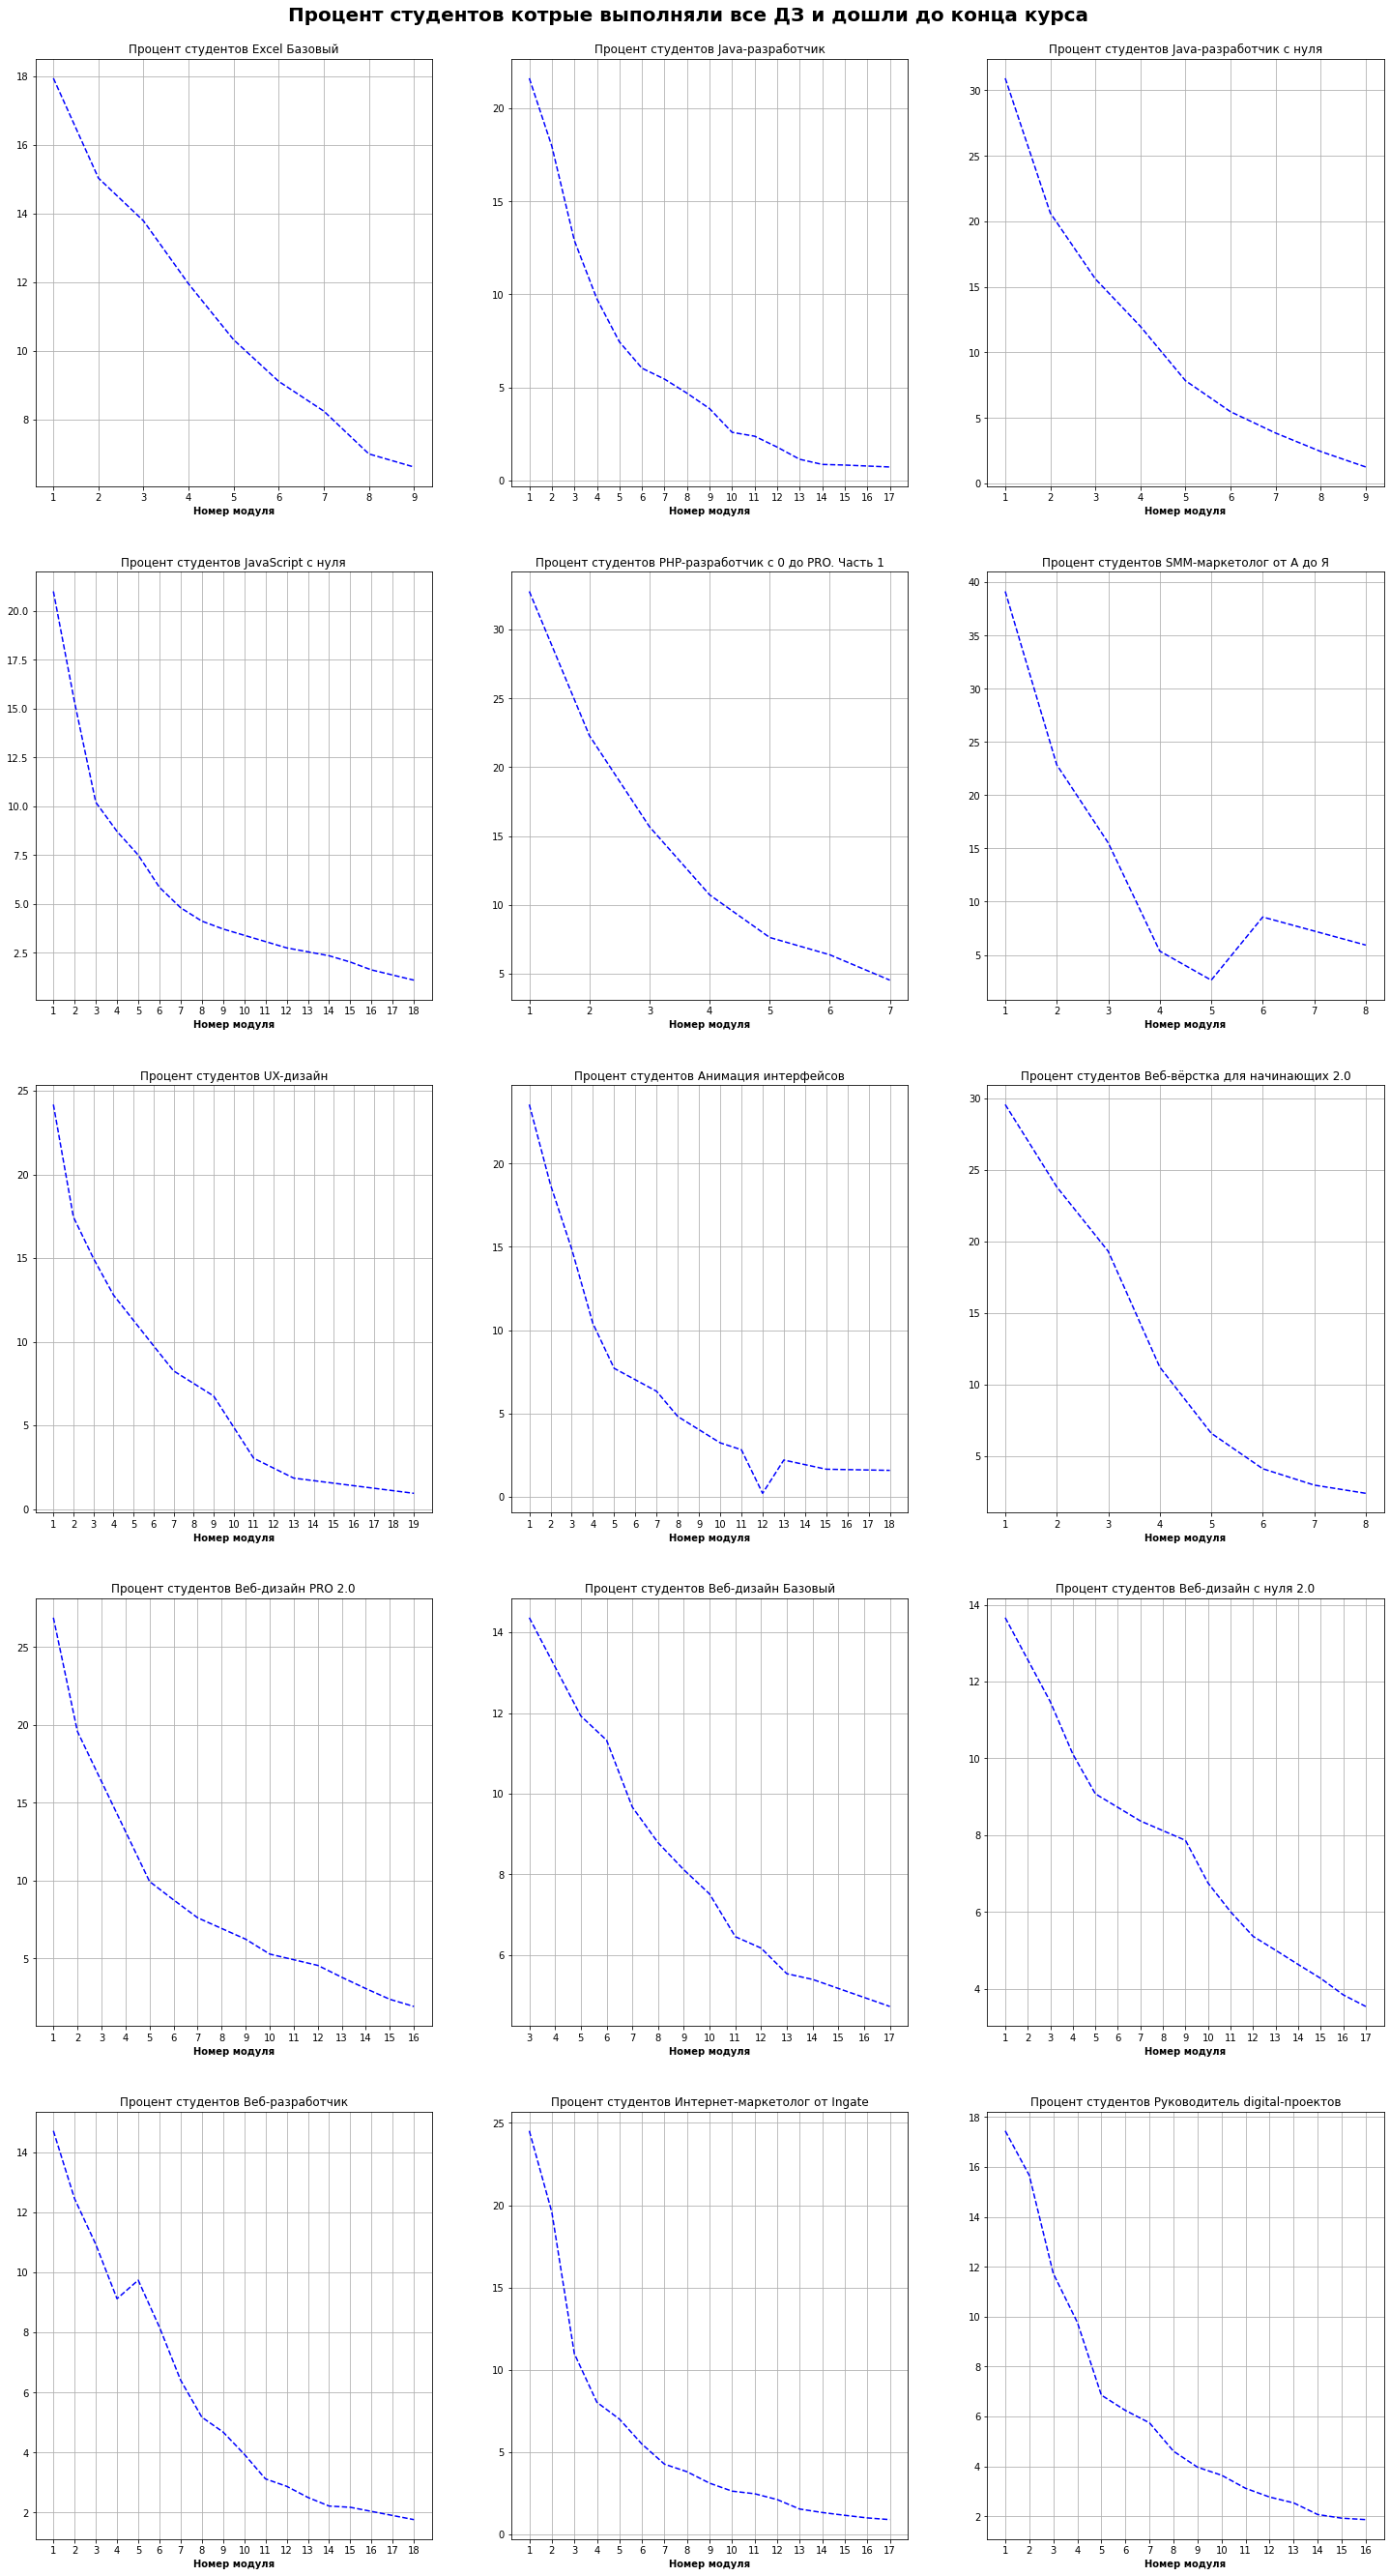

In [243]:
# построим графики 
index = 0 
fig, axes = plt.subplots(5, 3, figsize=(25,15))

for row in range(5):
    for column in range(3):
        plot = amount_of_students_pcts[amount_of_students_pcts.course_title == amount_of_students_pcts.course_title.unique()[index]]
        data =  plot['student_id']
        module = plot['module_number']
        axes[row, column].plot(module, data, color = 'b', ls = '--')
        axes[row, column].set_title(f'Процент студентов {amount_of_students_pcts.course_title.unique()[index]}')
        axes[row, column].set_xlabel('Номер модуля', fontweight = 'bold')
        axes[row, column].set_xticks(range(math.floor(min(module)), math.ceil(max(module))+1))
        axes[row, column].grid()
        index += 1
        

plt.suptitle('Процент студентов котрые выполняли все ДЗ и дошли до конца курса', y = 2.55, fontsize=20, fontweight = 'bold')
plt.subplots_adjust(top = 2.5)                
plt.show()

In [244]:
# посмотрим на минимальные проценты по завершению курсов 
pcts_by_field  = amount_of_students_pcts\
        .sort_values(by = 'student_id')\
        .groupby('course_title').first()\
        .sort_values(by = 'student_id')

pcts_by_field.drop(['module_number'], axis = 1)

,field,student_id
course_title,,
Анимация интерфейсов,Design,0.206469
Java-разработчик,Development,0.723888
Интернет-маркетолог от Ingate,Marketing,0.904088
UX-дизайн,Design,0.938380
JavaScript с нуля,Development,1.088710
Java-разработчик c нуля,Development,1.257396
Веб-разработчик,Development,1.766639
Руководитель digital-проектов,Business,1.867523
Веб-дизайн PRO 2.0,Design,1.912777


In [1464]:
# процент завершения курсов по сферам  
pcts_by_field_plot = pcts_by_field.groupby('field')['student_id'].agg('sum').reset_index().sort_values(by = 'student_id')

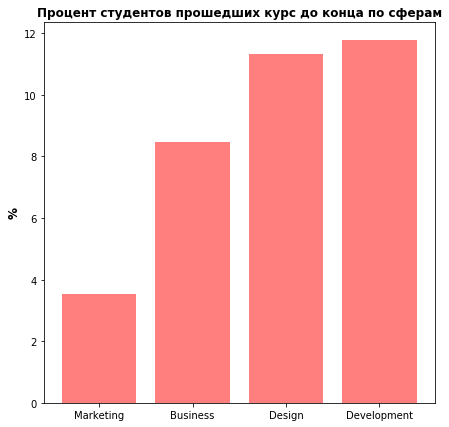

In [1465]:
# построим барплот 
x = pcts_by_field_plot['field']
y = pcts_by_field_plot['student_id']

plt.subplots(figsize=(7,7))

plt.bar(x,y, color = 'r', alpha = 0.5)
plt.title('Процент студентов прошедших курс до конца по сферам', fontweight = 'bold')
plt.ylabel('%', fontweight = 'bold', fontsize = 12)
plt.show()

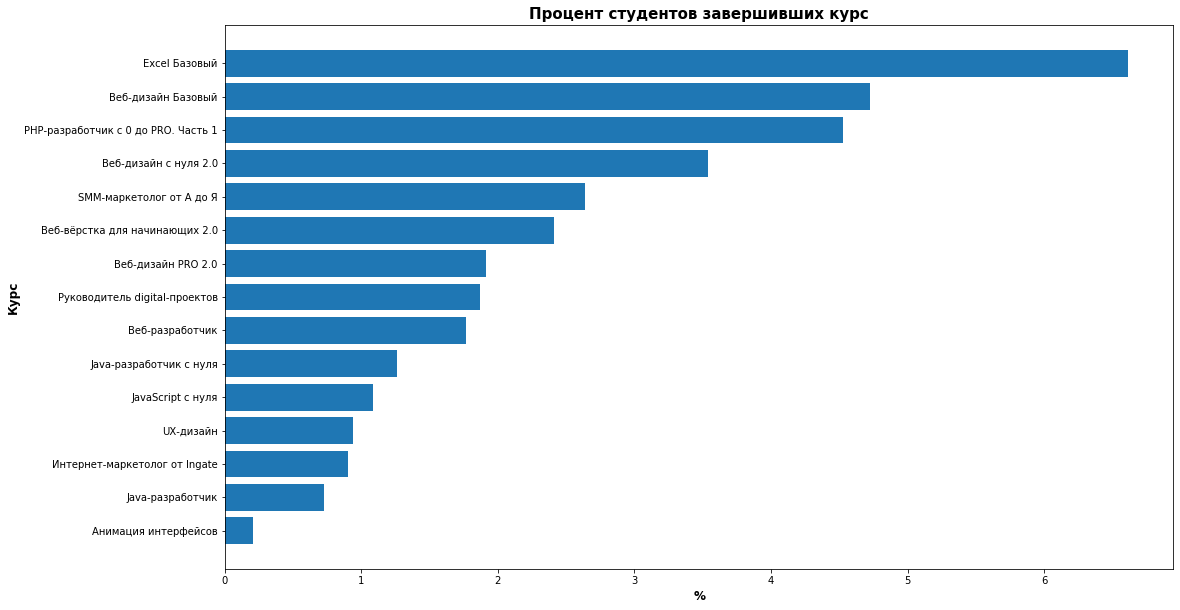

In [1466]:
# процент студентов которые завершили курсы 
x = pcts_by_field.index
y = pcts_by_field['student_id']

plt.subplots(figsize=(17,10))

plt.barh(x,y)
plt.title('Процент студентов завершивших курс', fontweight = 'bold', fontsize = 15)
plt.ylabel('Курс', fontweight = 'bold', fontsize = 12)
plt.xlabel('%', fontweight = 'bold', fontsize = 12)
plt.show()

### В какой сфере чаще проваливают домашние работы?

In [245]:
# отберем столбы для анализа выполнения дз 
df_2 = summary_df[['course_title', 'module_title', 'module_number',
                 'student_id', 'is_homework', 'field', 'lesson_title', 'status']]

In [248]:
# посчитаем количество работ по их статусам 
main_2 = df_2.groupby(['course_title', 'module_title', 'status', 'field']).size().reset_index()
main_2.rename(columns = {0:'amount'}, inplace=True)
main_2.head()

,course_title,module_title,status,field,amount
0,Excel Базовый,Визуализация данных Excel,done,Business,1167
1,Excel Базовый,Визуализация данных Excel,fail,Business,18
2,Excel Базовый,Визуализация данных Excel,start,Business,29
3,Excel Базовый,Визуализация данных Excel,wait,Business,1
4,Excel Базовый,Основной функционал Excel,done,Business,6214


In [249]:
# отберем строки где дз со статусом done или fail
fail_done = main_2[(main_2['status'] == 'fail')\
                | (main_2['status'] == 'done')].sort_values(['amount'],ascending=False)
fail_done

,course_title,module_title,status,field,amount
480,Веб-дизайн с нуля 2.0,Введение и первый результат,done,Design,15352
594,Интернет-маркетолог от Ingate,"SEO: больше, чем поисковая выдача (обновление ...",done,Marketing,14658
601,Интернет-маркетолог от Ingate,"Введение в интернет-маркетинг: цели, инструмен...",done,Marketing,13286
264,UX-дизайн,Профессия дизайнера в эпоху цифровых перемен,done,Design,7942
345,Веб-вёрстка для начинающих 2.0,Вводный модуль,done,Development,7629
...,...,...,...,...,...
554,Веб-разработчик,PHP. Взаимодействие с браузером,fail,Development,1
566,Веб-разработчик,PHP. Работа с файловой системой,fail,Development,1
162,JavaScript с нуля,Современный JavaScript; ES 2015,fail,Development,1
592,Интернет-маркетолог от Ingate,Email-маркетинг,fail,Marketing,1


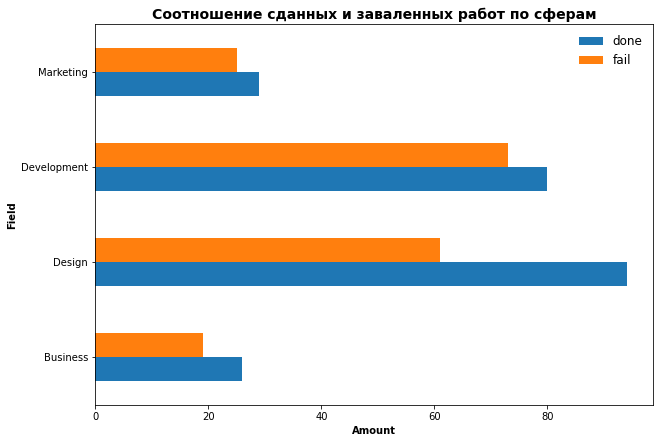

In [253]:
# посмотрим на соотношение сданных и заваленных работ по сферам
fail_done.groupby('status').field.value_counts().unstack(0).plot.barh(figsize=(10,7))
plt.title('Соотношение сданных и заваленных работ по сферам', fontsize = 14, fontweight = 'bold')
plt.ylabel('Field', fontweight = 'bold')
plt.xlabel('Amount', fontweight = 'bold')
plt.legend(fontsize = 12,frameon = False)
plt.show()

In [254]:
# теперь посчитаем процент работ по их статусам в модуле 
# процент работ (done, fail, start, wait) по модулям 
pcts_by_module = main_2.groupby(['field','course_title', 'module_title', 'status']).agg({'amount': 'sum'})
pcts_by_module = pcts_by_module.groupby(level = 2).apply(lambda x: 100 * x / x.sum()).reset_index()
pcts_by_module.head(10)

,field,course_title,module_title,status,amount
0,Business,Excel Базовый,Визуализация данных Excel,done,96.049383
1,Business,Excel Базовый,Визуализация данных Excel,fail,1.481481
2,Business,Excel Базовый,Визуализация данных Excel,start,2.386831
3,Business,Excel Базовый,Визуализация данных Excel,wait,0.082305
4,Business,Excel Базовый,Основной функционал Excel,done,95.717807
5,Business,Excel Базовый,Основной функционал Excel,fail,0.646950
6,Business,Excel Базовый,Основной функционал Excel,start,3.635243
7,Business,Excel Базовый,Основной функционал Excel (продолжение),done,97.712316
8,Business,Excel Базовый,Основной функционал Excel (продолжение),fail,0.532748
9,Business,Excel Базовый,Основной функционал Excel (продолжение),start,1.754936


In [255]:
# оставим работы со статусом fail и уберем строки где зайфейлено меньше 1% работ 
pcts_fail = pcts_by_module[pcts_by_module['status'] == 'fail'].sort_values(by = 'amount', ascending=False)
pcts_fail = pcts_fail[pcts_fail['amount'] >= 1]

pcts_fail

,field,course_title,module_title,status,amount
376,Development,Java-разработчик,Итоговая тема,fail,33.333333
515,Development,PHP-разработчик с 0 до PRO. Часть 1,Курсовая работа,fail,25.581395
503,Development,JavaScript с нуля,Экзаменационное задание,fail,14.814815
703,Marketing,Интернет-маркетолог от Ingate,Финальное тестирование,fail,10.714286
258,Design,Веб-дизайн Базовый,Дипломная работа,fail,8.666667
...,...,...,...,...,...
93,Design,UX-дизайн,Data driven design: теория и практика,fail,1.039347
104,Design,UX-дизайн,UX-проектирование. Паттерны и психология польз...,fail,1.027190
319,Design,Веб-дизайн с нуля 2.0,Декомпозиция,fail,1.019332
606,Development,Веб-разработчик,О программе,fail,1.015228


In [256]:
# сгруппируем и посчитаем процент заваленных работ 
pcts_fail_group = pcts_fail.groupby(['field', 'module_title'])['amount'].agg('sum').sort_values(ascending=False).reset_index()

# оставляем те строки где общий процент заваленных работ больше 5%
top_fail = pcts_fail_group[pcts_fail_group['amount'] >= 5].round(2)
top_fail

,field,module_title,amount
0,Development,Итоговая тема,33.33
1,Development,Курсовая работа,25.58
2,Development,Экзаменационное задание,14.81
3,Marketing,Финальное тестирование,10.71
4,Design,Дипломная работа,8.67
5,Design,Техника успешной презентации,7.84
6,Development,"SQL БД. Концепция, назначение",5.66


In [257]:
# посмотрим какой процент работ заваливают по сферам
top_fail.groupby('field')['amount'].agg('sum').sort_values(ascending = False).reset_index()

,field,amount
0,Development,79.38
1,Design,16.51
2,Marketing,10.71


На всех курсах процент студентов, которые выполнили все ДЗ и дошли до конца курса, довольно низкий. 
Минимальный процент на курсе «Анимация интерфейсов» - 0.2, а максимальный на курсе «Excel Базовый» - 6.61. 
По сферам наибольший процент студентов которые заканчивают курсы, относятся к сфере Разработки, реже заканчивают курсы, которые относятся к сфере Маркетинга. 
По соотношению сданных и заваленных работ можно сделать вывод, что реже заваливают работы в сфере Дизайна, чаще в сфере Маркетинга. 
Самые высокие проценты среди заваленных работ по модулям с названиями «Итоговая тема» и «Курсовая работа», среди сфер лидирует Разработка.
Если сложить процент работ которые не сданы по сферам, то самый высокий процент в сфере Разработки.

В общем на технических специальностях не очень-то и легко учиться!
ЧТД. 
